# ApRES processing step 2: Obtaining velocity profiles.

In [1]:
# Load libraries
import sys
import sys
import pickle
sys.path.append("../../../xapres_package/")
import ApRESDefs
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker 

import xarray as xr
import importlib
import pandas as pd
import math
from datetime import datetime, timedelta, date
from scipy.stats import linregress
from helpers import *

importlib.reload(ApRESDefs)
xa = ApRESDefs.xapres(loglevel='debug')

DEBUG    19:39:01 	 ApRESDefs.py @function _setup_logging line 615 - Stream logging level set to DEBUG
DEBUG    19:39:01 	 ApRESDefs.py @function _setup_logging line 616 - Add console handler to logger
DEBUG    19:39:01 	 ApRESDefs.py @function _setup_logging line 629 - File logging level set to DEBUG


The folder `strain_rates` investigates many of the decisions made in obtaining vertical velocities. Notably, `A11`, `A13`, and `A14` decide on the coherence window size. 

In [2]:
# helper functions
def drop_profile_range(profiles,shift_value): # do 50 m everywhere to avoid surface effects
    profiles_adjust = profiles.where(profiles.profile_range > shift_value, drop = True)
    return profiles_adjust
    
def convert_to_doy(da):
    da['doy_decimal'] = da.time.dt.dayofyear + (da.time.dt.hour / 24) + (da.time.dt.minute / 1440) + (da.time.dt.second / 86400)
    return da
    
# generic function for determining displacements
def displacements(b1,b2, win_cor):
    dz, co, phi = xa.generate_range_diff(b1,b2,win_cor,win_cor,None,0,0.95)
    dz=dz.assign(coherence=(['time','profile_range'],co))
    dz_new = dz.where(abs(dz.coherence) > 0.95).drop_duplicates('time')
    return dz_new

# generic function for vertical velocities and strain
def vv_strain(dz,noise_floor, bin_adjust=1):
    vv = dz.range_diff / dz.time_diff * 31536000
    vv_adjust = vv - vv.isel(profile_range = range(0,bin_adjust)).mean(dim='profile_range')
    vv_err = dz.err / dz.time_diff * 31536000
    vv_mean_err = (vv_err.isel(profile_range = range(0,bin_adjust))**2).sum(dim='profile_range')/bin_adjust
    vv_adjust_err = np.sqrt(vv_err**2 + vv_mean_err)

    fit=vv_adjust.where(vv_adjust.profile_range <=noise_floor).polyfit('profile_range',1,full=True)
    r2 = 1-fit.polyfit_residuals/((vv_adjust.where(vv.profile_range <=noise_floor)-vv.where(vv_adjust.profile_range <=noise_floor).mean())**2).sum(dim='profile_range')
    
    slope = fit.polyfit_coefficients.sel(degree=1)*vv_adjust.profile_range+fit.polyfit_coefficients.sel(degree=0)
    residual = vv_adjust-slope
    residual = residual.where(residual.profile_range <=noise_floor,drop=True)
    slope_errs = np.sqrt((1/(len(residual.profile_range)-2))*(((residual**2).sum(dim='profile_range'))/((residual.profile_range - residual.profile_range.mean())**2).sum()))

    int_err = slope_errs*np.sqrt(((vv_adjust.profile_range)**2).sum()/len(vv_adjust.profile_range))
    ds = vv_adjust.to_dataset(name='vv')
    ds['err'] = vv_adjust_err
    ds['slope']= fit.polyfit_coefficients.sel(degree=1)
    ds['intercept']=fit.polyfit_coefficients.sel(degree=0)
    ds['fit'] = slope
    ds['slope_err'] = slope_errs
    ds['int_err'] = int_err
    ds = convert_to_doy(ds)
    return ds

# method zero: no coarsening
def no_coarsen_vv(ds, win_cor, noise_floor, bin_adjust):
    b1 = ds.isel(time=range(0,len(ds)-1))
    b2 = ds.isel(time=range(1,len(ds)))
    dz = displacements(b1,b2, win_cor)
    ds = vv_strain(dz,noise_floor,bin_adjust)
    return ds

def plot_vv_strain(ds,doy=True):
    fig, axs = plt.subplots(nrows = 2, sharex=True, figsize = (10,5),layout = 'constrained')
    vv = convert_to_doy(ds.vv)
    if doy:
        vv.plot(ax=axs[0],x='doy_decimal')
        axs[1].errorbar(ds.doy_decimal,ds.slope,ds.slope_err,marker='.')
    else:
        vv.plot(ax=axs[0],x='time')
        axs[1].errorbar(ds.time.values,ds.slope,ds.slope_err,marker='.')
    axs[0].set_title('Vertical Velocity [m y$^{-1}$]')
    axs[0].invert_yaxis()
    axs[0].set_xlabel('')
    axs[1].set_title('Strain Rate [y$^{-1}$]')
    axs[1].set_ylabel('strain rate [y$^{-1}$]')
    axs[1].set_xlabel('DOY 2022')

# method 3: Leapfrog over a lag and take average
def leapfrog_mean_vv(ds,lag,win_cor,noise_floor,bin_adjust):
    def err_from_mean(err,lag):
        new_err = np.sqrt((err**2).coarsen(time = lag,boundary='pad').sum()/lag)
        return new_err
    b1 = ds.isel(time=range(0,len(ds)-lag))
    b2 = ds.isel(time=range(lag,len(ds)))
    dz = displacements(b1,b2, win_cor)
    ds_raw = vv_strain(dz,noise_floor,bin_adjust)

    ds = ds_raw.coarsen(time = lag,boundary='pad').mean()
    ds['err'] = err_from_mean(ds_raw.err,lag)
    ds['slope_err'] = err_from_mean(ds_raw.slope_err,lag)
    ds['int_err'] = err_from_mean(ds_raw.int_err,lag)
    return ds

def evaluate_vv_estimates(vv):
    fig, axs = plt.subplots(ncols = 2, figsize = (10,5),layout = 'constrained')
    axs[0].errorbar(vv.vv.mean(dim='time'),vv.profile_range,yerr=None,xerr=vv.err.mean(dim='time'),marker='.',linestyle='None', label = 'mean velocity')
    axs[0].fill_betweenx(vv.profile_range, vv.vv.mean(dim='time')-vv.vv.std(dim='time'), vv.vv.mean(dim='time')+vv.vv.std(dim='time'), color='gray', alpha=0.5, label='velocity std. dev.')
    axs[0].axvline(x=0, color='k', linestyle='--', label='v=0')
    axs[0].invert_yaxis()
    surf_v = (vv.vv.isel(profile_range=0))
    axs[0].set_title(f'Mean surface vel.: {float(surf_v.mean()):.3} $\pm$ {float(surf_v.std()):.3} m y$^{-1}$')
    axs[0].set_ylabel('depth [m]')
    axs[0].set_xlabel('velocity [m y$^{-1}$]')
    axs[0].legend()
    
    axs[1].hist(vv.slope,bins=50)
    mean_slope = vv.slope.mean()
    std_slope = vv.slope.std()
    mean_err = vv.slope_err.mean()
    axs[1].axvline(x=float(mean_slope), color='k', label='Mean Slope')
    axs[1].axvline(x=float(mean_slope-std_slope), color='k', linestyle='--', label='Slope Std. Dev.')
    axs[1].axvline(x=float(mean_slope+std_slope), color='k', linestyle='--')
    axs[1].axvline(x=float(mean_slope-mean_err), color='r', linestyle='--', label='Mean Slope Error')
    axs[1].axvline(x=float(mean_slope+mean_err), color='r', linestyle='--')
    axs[1].legend()
    axs[1].set_ylabel('count')
    axs[1].set_xlabel('strain rate [y$^{-1}$]')
    
    axs[1].set_title(f'Mean strain rate: {float(mean_slope):.3} $\pm$ {float(std_slope):.3} y$^{-1}$')

def evaluate_vv_fine(vv):
    label_dict = {
        'groupby': ['time.week','time.hour'],
        'label': ['week of calendar year','hour of day'],
        'title': ['yearly climatology', 'daily climatology']
    }
    fig, axs = plt.subplots(nrows = 2, figsize = (10,5),layout = 'constrained')
    for i in range(2):
        gb = vv_fine.slope.groupby(label_dict['groupby'][i])
        median = gb.median(dim='time')
        slope_std = gb.std(dim='time')
        median.plot(ax=axs[i],label='slope',color='k',marker='o')
        axs[i].set_ylabel('strain rate [y$^{-1}$]')
        axs[i].set_title(label_dict['title'][i])
        axs[i].set_xlabel(label_dict['label'][i])
        ax1 = axs[i].twinx()
        slope_std.plot(ax=ax1,label='stddev',color='r',marker='o')
        ax1.set_title('')
        ax1.set_ylabel('Stddev')
        ax1.spines['right'].set_color('red')    
        ax1.tick_params(axis='y', colors='red') 
        ax1.yaxis.label.set_color('red')    

def fourier_vvfine(vv_fine):
    def fourier_analysis(timeseries_interp):
        time_numeric = (timeseries_interp['time'] - timeseries_interp['time'][0]).astype('timedelta64[s]').astype('float64')/1e9
        fft_values = np.fft.fft(timeseries_interp.values)
        frequencies = np.fft.fftfreq(len(timeseries_interp), np.diff(time_numeric)[0])
        power_spectrum = np.abs(fft_values)**2
        positive_frequencies = frequencies[frequencies > 0]
        positive_power_spectrum = power_spectrum[frequencies > 0]
        return positive_frequencies,positive_power_spectrum
    plt.figure(figsize=(10, 5))
    positive_frequencies,positive_power_spectrum = fourier_analysis(vv_fine.slope.interpolate_na(dim='time', method='linear'))
    plt.plot(1/positive_frequencies/3600, positive_power_spectrum,label = 'slope')
    positive_frequencies_err,positive_power_spectrum_err = fourier_analysis(vv_fine.slope_err.interpolate_na(dim='time', method='linear'))
    plt.plot(1/positive_frequencies_err/3600, positive_power_spectrum_err,label='slope err')
    plt.axvline(x=24,color = 'k',linestyle = '--')
    plt.legend()
    #plt.xscale('log')
    plt.xlim([0,100])
    plt.yscale('log')
    plt.xlabel('Period (hours)')
    plt.ylabel('Power Spectrum')
    plt.title('Fourier analysis of strain rate estimate')


<>:91: SyntaxWarning: invalid escape sequence '\p'
<>:109: SyntaxWarning: invalid escape sequence '\p'
<>:91: SyntaxWarning: invalid escape sequence '\p'
<>:109: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_453/1773200203.py:91: SyntaxWarning: invalid escape sequence '\p'
  axs[0].set_title(f'Mean surface vel.: {float(surf_v.mean()):.3} $\pm$ {float(surf_v.std()):.3} m y$^{-1}$')
/tmp/ipykernel_453/1773200203.py:109: SyntaxWarning: invalid escape sequence '\p'
  axs[1].set_title(f'Mean strain rate: {float(mean_slope):.3} $\pm$ {float(std_slope):.3} y$^{-1}$')


## A11 Lake Drainage

/home/jovyan/xapres_package/notebooks/test_notes/streamlined_methods/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom


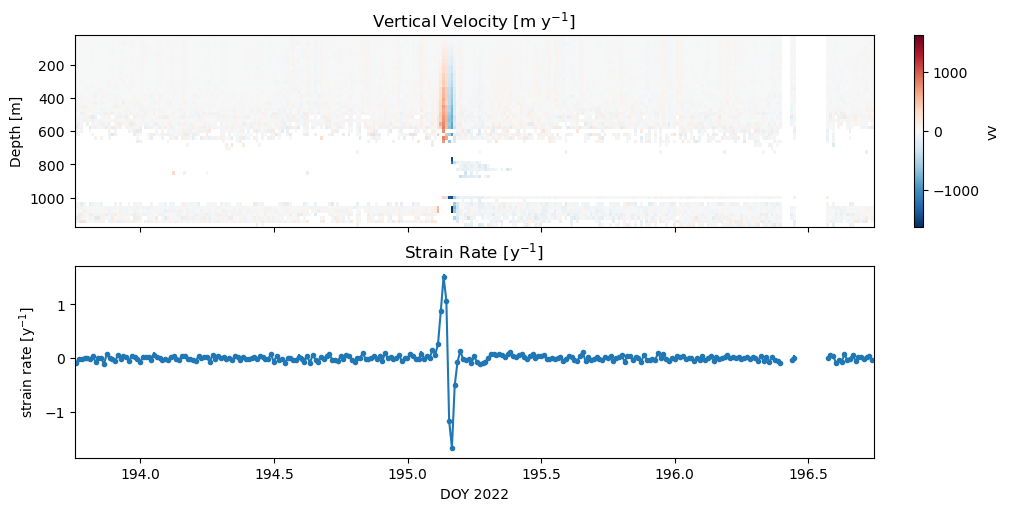

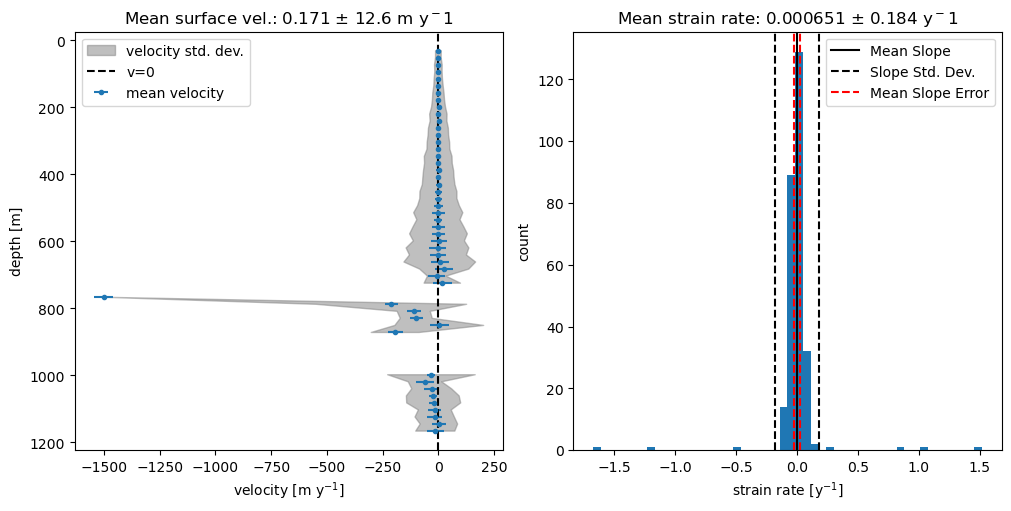

In [56]:
with open(f'A11_22S.pickle', 'rb') as handle:
    ds = pickle.load(handle)
ds_trim = ds.sel(time=slice('2022-07-12 18:00', '2022-07-15 18:00'))
ds_adjust = drop_profile_range(ds_trim,20)
vv = no_coarsen_vv(ds_adjust, 50, 500, 2)
plot_vv_strain(vv)
evaluate_vv_estimates(vv)

## A13 Lake Drainage

/home/jovyan/xapres_package/notebooks/test_notes/streamlined_methods/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom


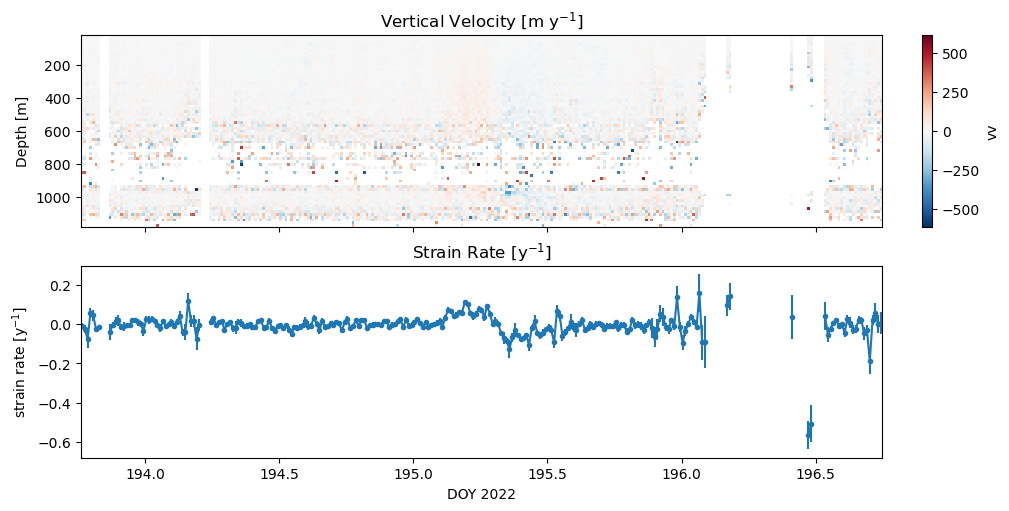

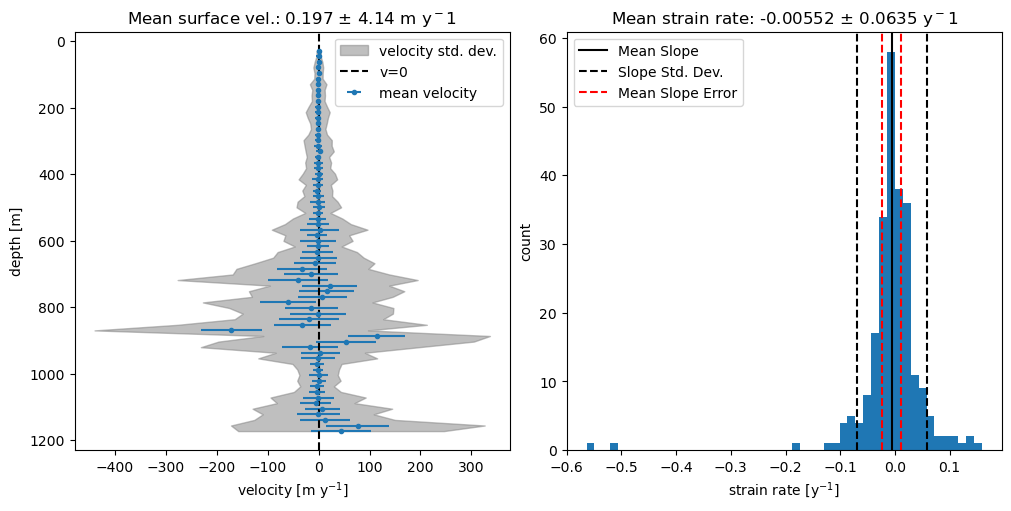

In [57]:
with open(f'A13_22S.pickle', 'rb') as handle:
    ds = pickle.load(handle)
ds_trim = ds.sel(time=slice('2022-07-12 18:00', '2022-07-15 18:00'))
ds_adjust = drop_profile_range(ds_trim,20)
vv = no_coarsen_vv(ds_adjust, 20, 500, 2)
plot_vv_strain(vv)
evaluate_vv_estimates(vv)

## A14 Lake Drainage

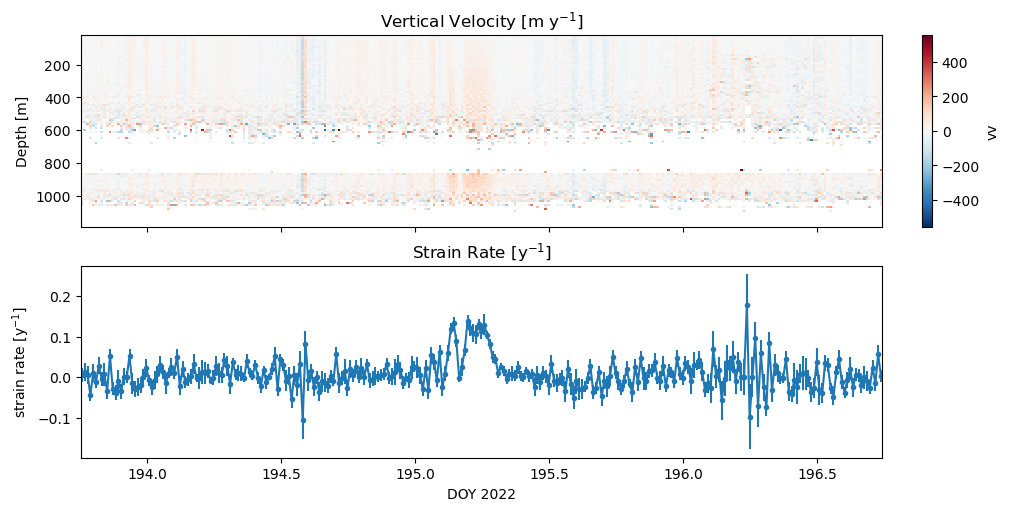

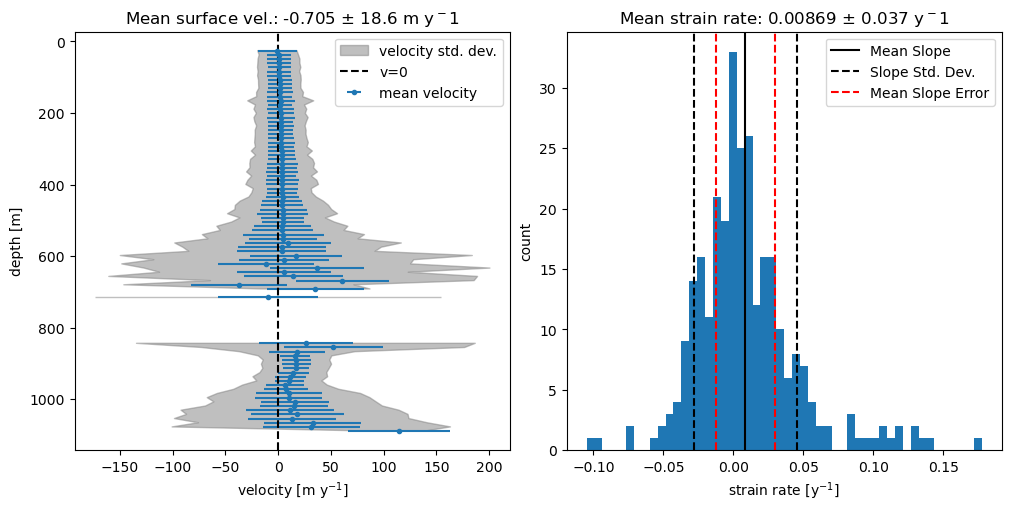

In [3]:
with open(f'A14_22S.pickle', 'rb') as handle:
    ds = pickle.load(handle)
ds_trim = ds.sel(time=slice('2022-07-12 18:00', '2022-07-15 18:00'))
ds_adjust = drop_profile_range(ds_trim,20)
vv = no_coarsen_vv(ds_adjust, 50, 500, 2)
plot_vv_strain(vv)
evaluate_vv_estimates(vv)

# Seasonal-scale vertical velocities and strain rates

## A11 S22

/home/jovyan/xapres_package/notebooks/test_notes/streamlined_methods/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom


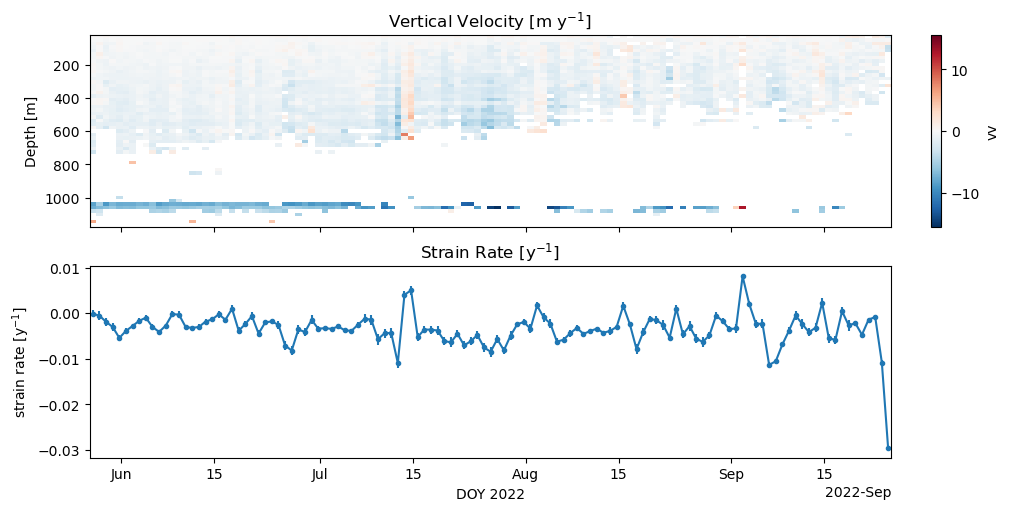

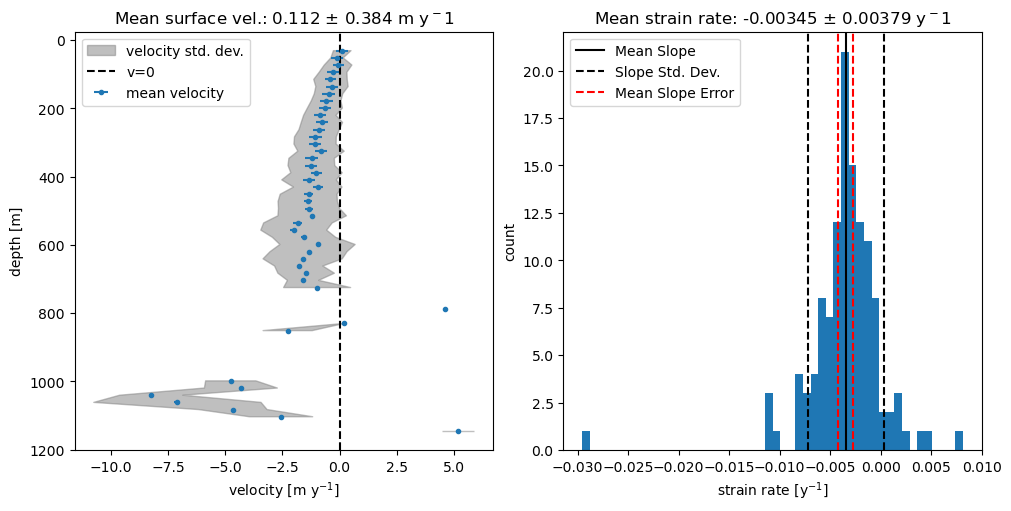

In [166]:
with open(f'A11_22S.pickle', 'rb') as handle:
    ds = pickle.load(handle)
ds_adjust = drop_profile_range(ds,20)
vv = leapfrog_mean_vv(ds_adjust,96, 50, 500, 2)
plot_vv_strain(vv,False)
evaluate_vv_estimates(vv)

/home/jovyan/xapres_package/notebooks/test_notes/streamlined_methods/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom


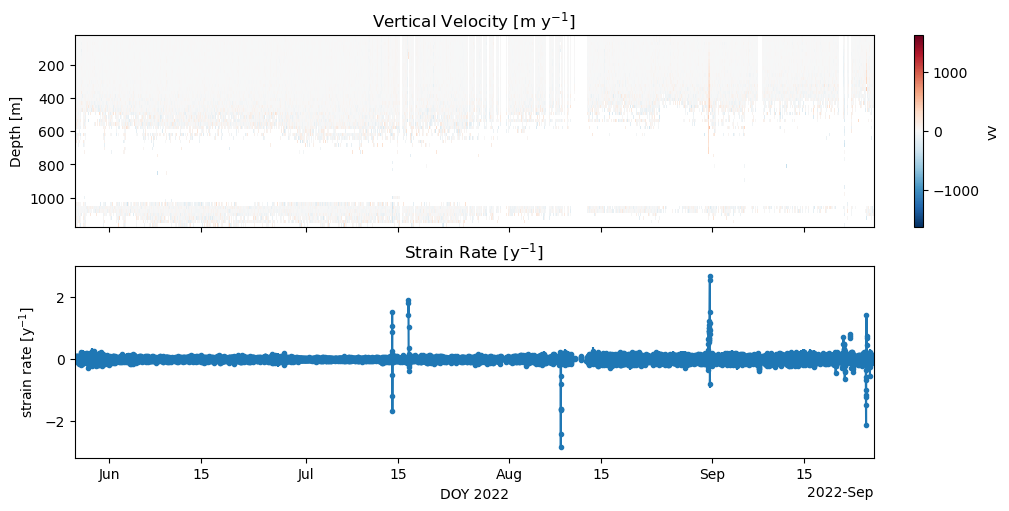

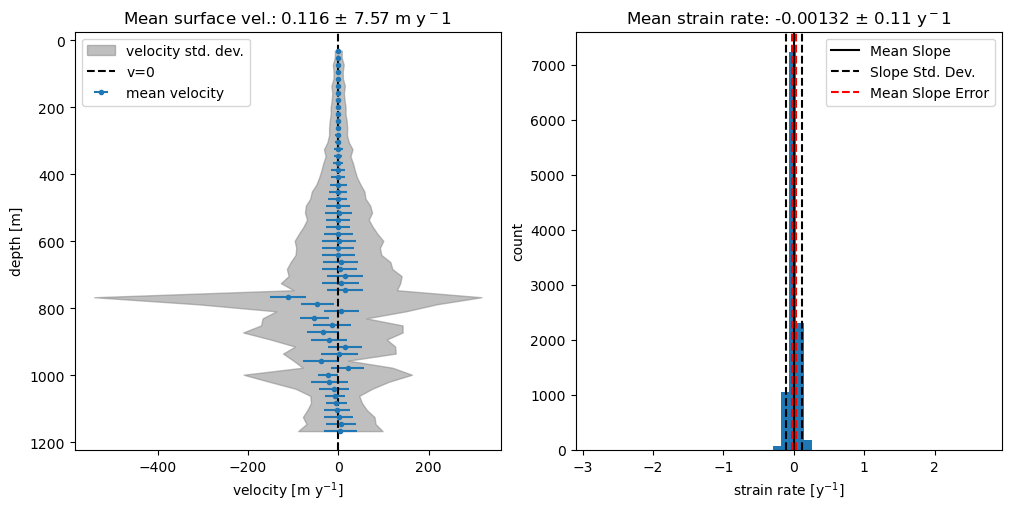

In [167]:
vv_fine = no_coarsen_vv(ds_adjust,50,500,2)
plot_vv_strain(vv_fine,False)
evaluate_vv_estimates(vv_fine)

/srv/conda/envs/notebook/lib/python3.12/site-packages/xarray/core/accessor_dt.py:441: FutureWarning: dt.weekofyear and dt.week have been deprecated. Please use dt.isocalendar().week instead.
  warnings.warn(
/tmp/ipykernel_956/1773200203.py:136: UserWarning: Converting non-nanosecond precision timedelta values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  time_numeric = (timeseries_interp['time'] - timeseries_interp['time'][0]).astype('timedelta64[s]').astype('float64')/1e9
/tmp/ipykernel_956/1773200203.py:136: UserWarning: Converting non-nanosecond precision timedelta values to nanosecond precision. This behavior can eventually be relaxed in xarr

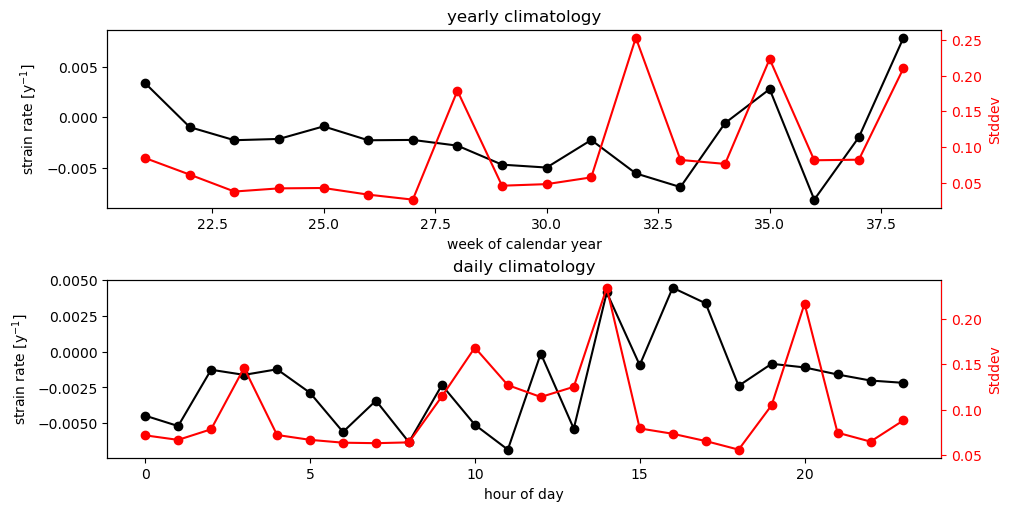

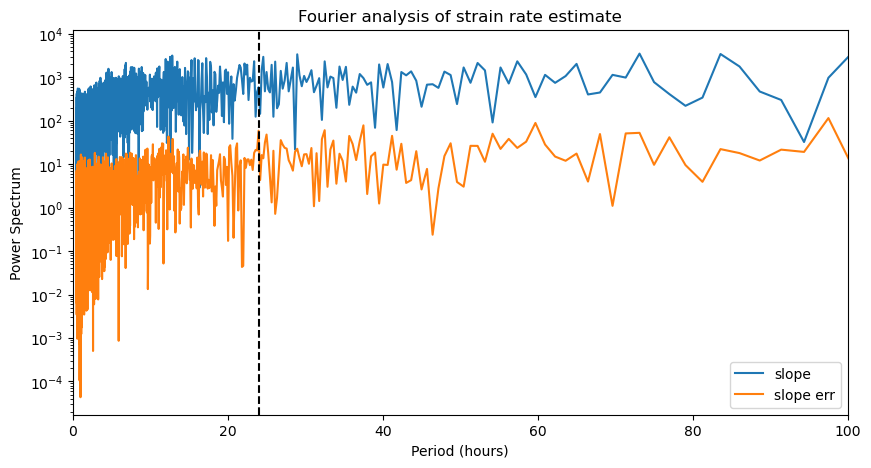

In [168]:
evaluate_vv_fine(vv_fine)
fourier_vvfine(vv_fine)

## A11 Winter

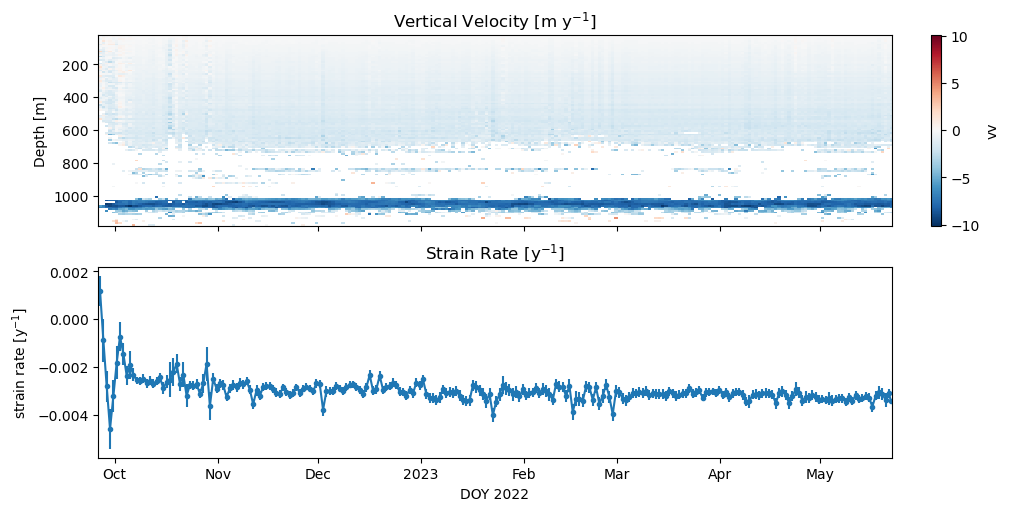

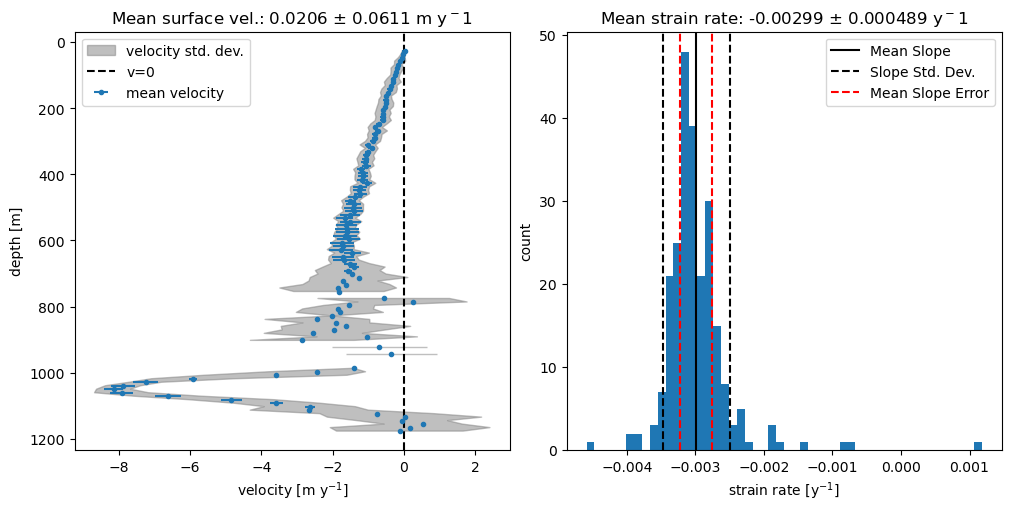

In [169]:
with open(f'A11_22W.pickle', 'rb') as handle:
    ds = pickle.load(handle)
ds_adjust = drop_profile_range(ds,20)
vv = leapfrog_mean_vv(ds_adjust,96, 50, 500, 2)
plot_vv_strain(vv,False)
evaluate_vv_estimates(vv)

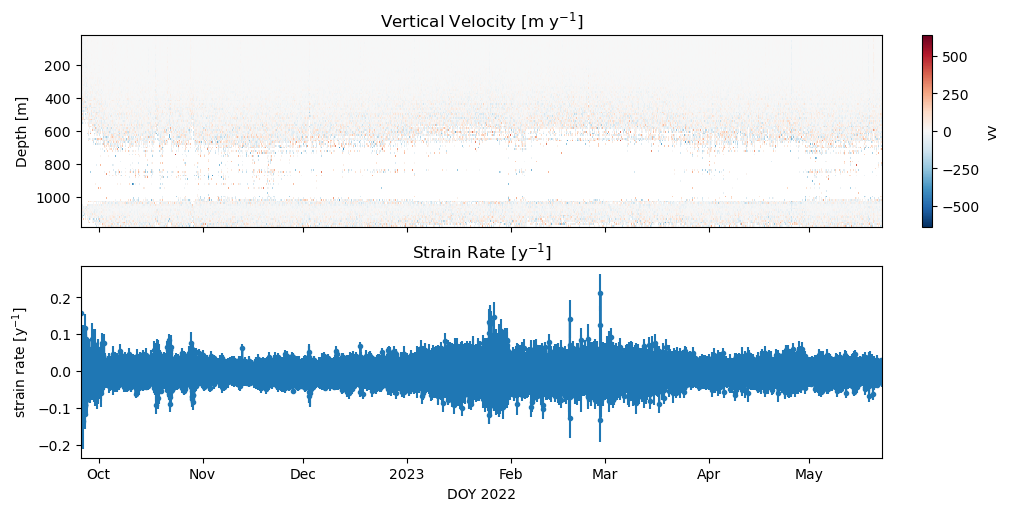

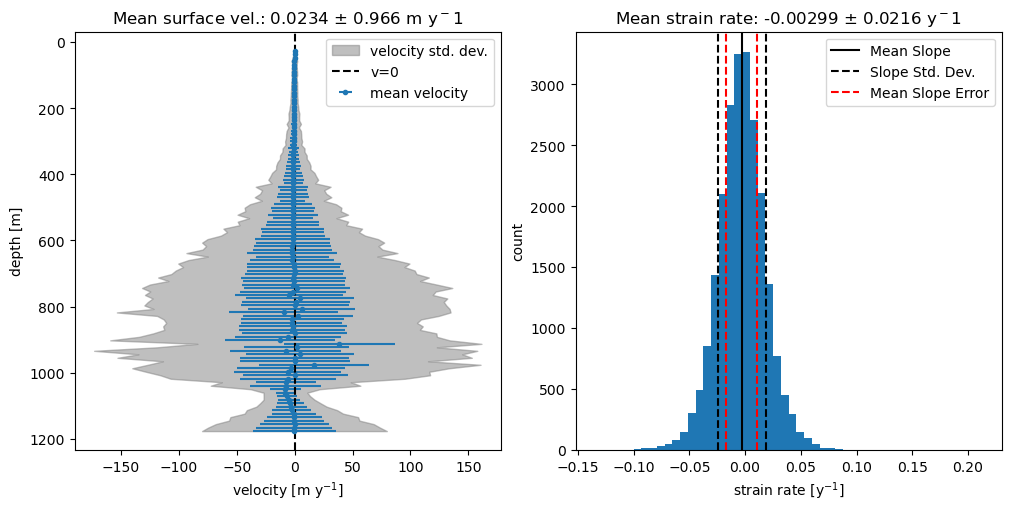

In [170]:
vv_fine = no_coarsen_vv(ds_adjust,50,500,2)
plot_vv_strain(vv_fine,False)
evaluate_vv_estimates(vv_fine)


/srv/conda/envs/notebook/lib/python3.12/site-packages/xarray/core/accessor_dt.py:441: FutureWarning: dt.weekofyear and dt.week have been deprecated. Please use dt.isocalendar().week instead.
  warnings.warn(
/tmp/ipykernel_956/1773200203.py:136: UserWarning: Converting non-nanosecond precision timedelta values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  time_numeric = (timeseries_interp['time'] - timeseries_interp['time'][0]).astype('timedelta64[s]').astype('float64')/1e9
/tmp/ipykernel_956/1773200203.py:136: UserWarning: Converting non-nanosecond precision timedelta values to nanosecond precision. This behavior can eventually be relaxed in xarr

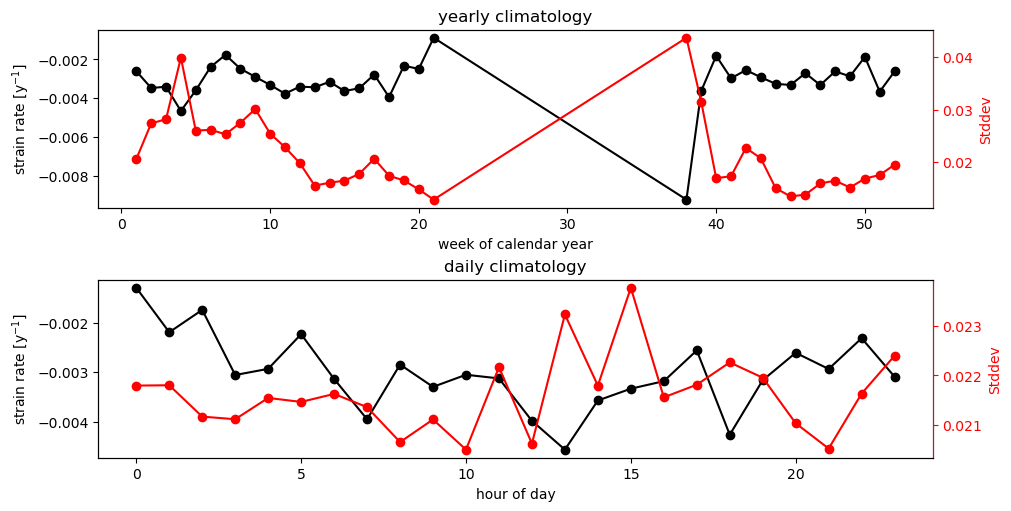

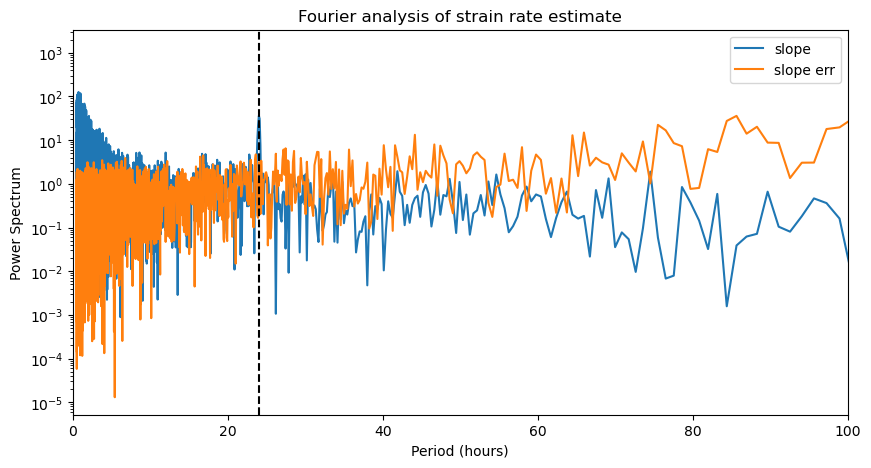

In [171]:
evaluate_vv_fine(vv_fine)
fourier_vvfine(vv_fine)

## A13 S22

/home/jovyan/xapres_package/notebooks/test_notes/streamlined_methods/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom


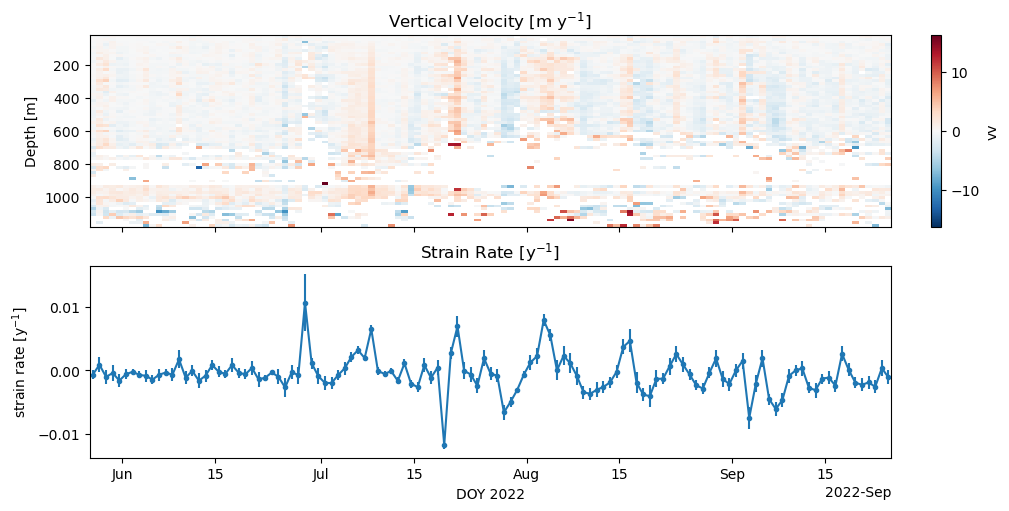

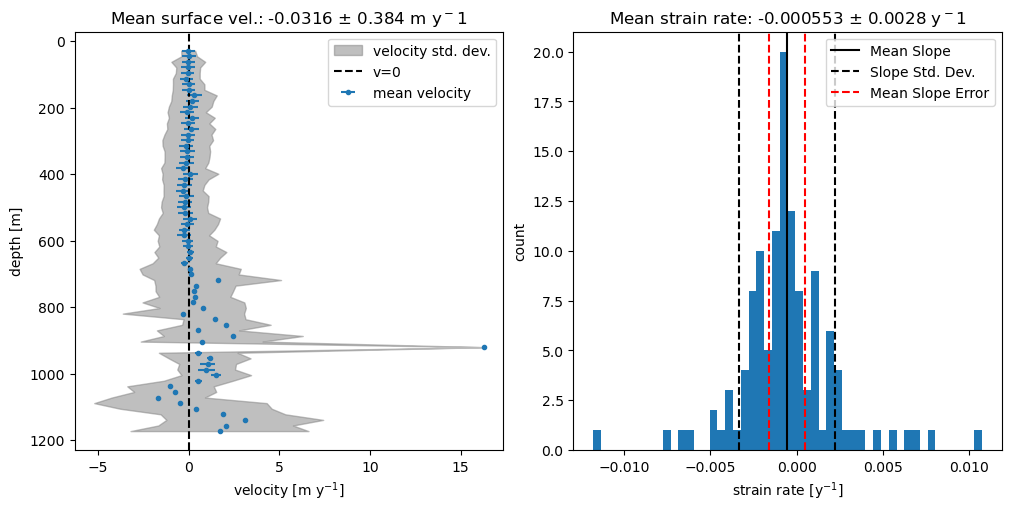

In [172]:
with open(f'A13_22S.pickle', 'rb') as handle:
    ds = pickle.load(handle)
ds_adjust = drop_profile_range(ds,20)
vv = leapfrog_mean_vv(ds_adjust,96, 20, 500, 2)
plot_vv_strain(vv,False)
evaluate_vv_estimates(vv)

/home/jovyan/xapres_package/notebooks/test_notes/streamlined_methods/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom


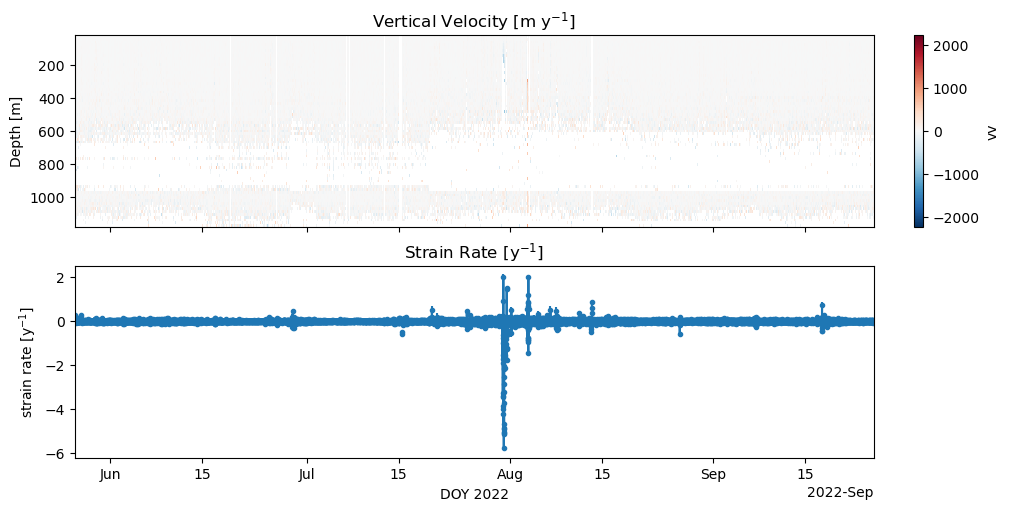

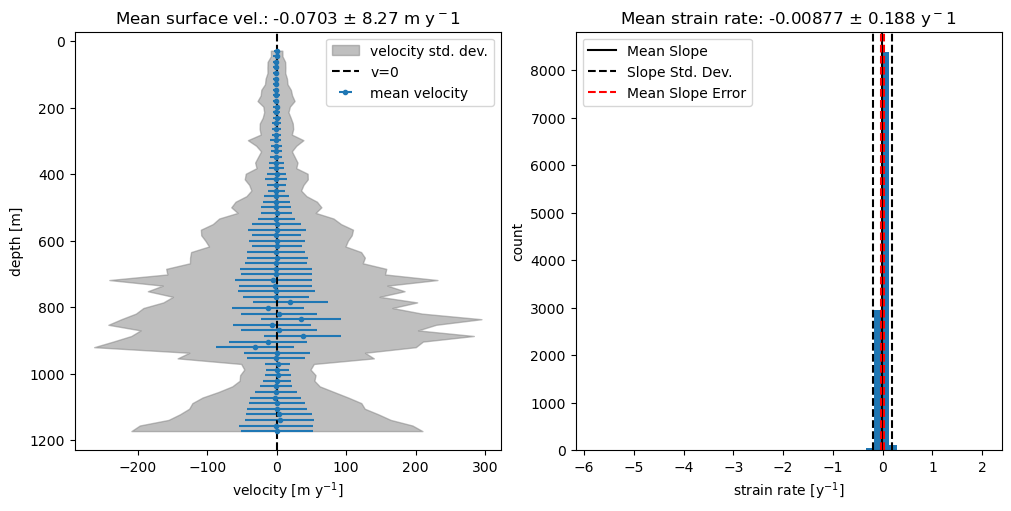

In [173]:
vv_fine = no_coarsen_vv(ds_adjust,20,500,2)
plot_vv_strain(vv_fine,False)
evaluate_vv_estimates(vv_fine)


/srv/conda/envs/notebook/lib/python3.12/site-packages/xarray/core/accessor_dt.py:441: FutureWarning: dt.weekofyear and dt.week have been deprecated. Please use dt.isocalendar().week instead.
  warnings.warn(
/tmp/ipykernel_956/1773200203.py:136: UserWarning: Converting non-nanosecond precision timedelta values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  time_numeric = (timeseries_interp['time'] - timeseries_interp['time'][0]).astype('timedelta64[s]').astype('float64')/1e9
/tmp/ipykernel_956/1773200203.py:136: UserWarning: Converting non-nanosecond precision timedelta values to nanosecond precision. This behavior can eventually be relaxed in xarr

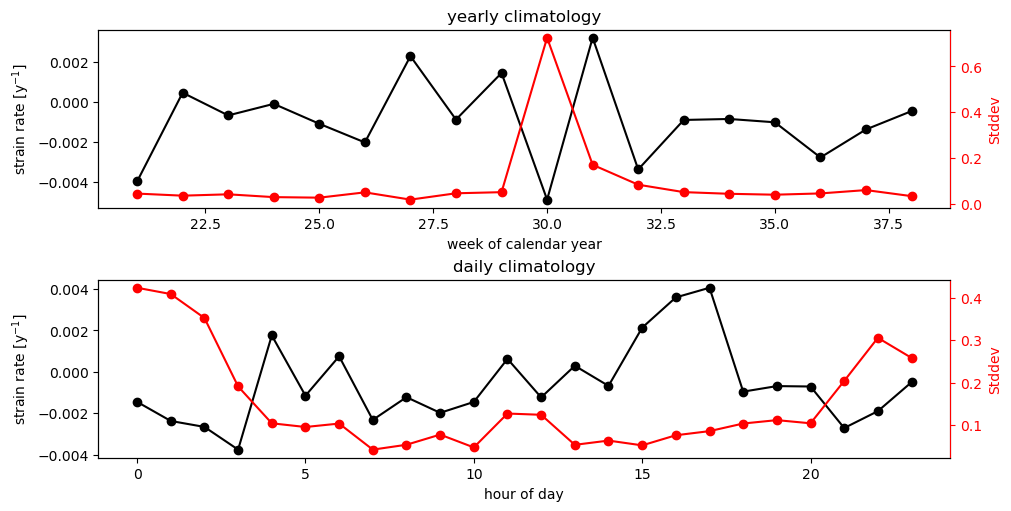

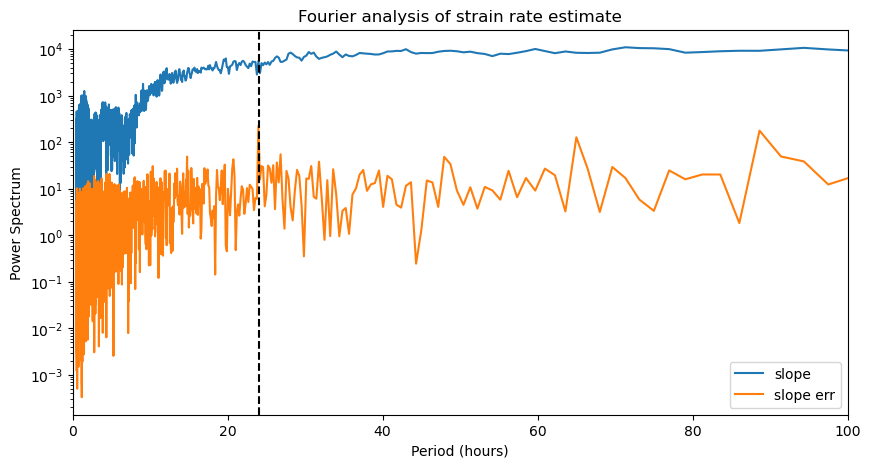

In [174]:
evaluate_vv_fine(vv_fine)
fourier_vvfine(vv_fine)

## A13 Winter

/home/jovyan/xapres_package/notebooks/test_notes/streamlined_methods/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom


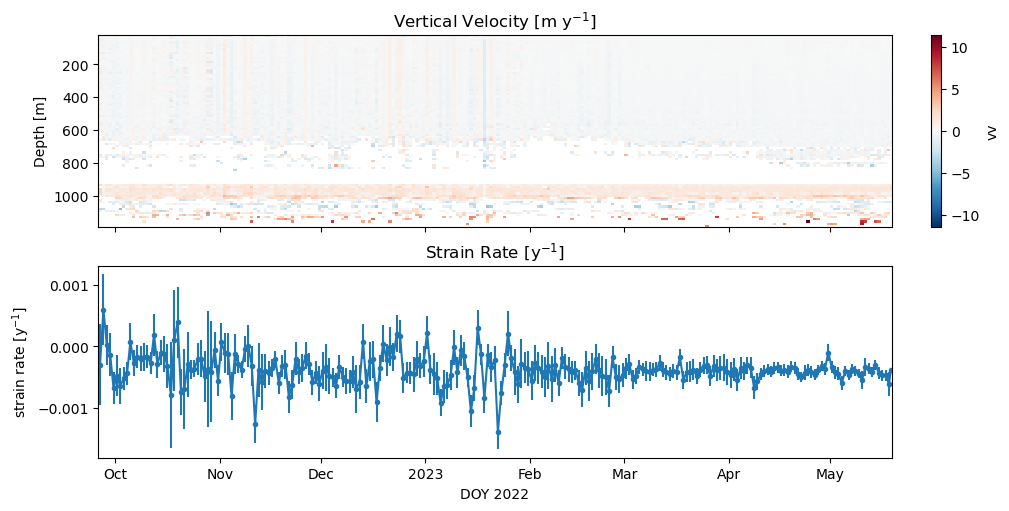

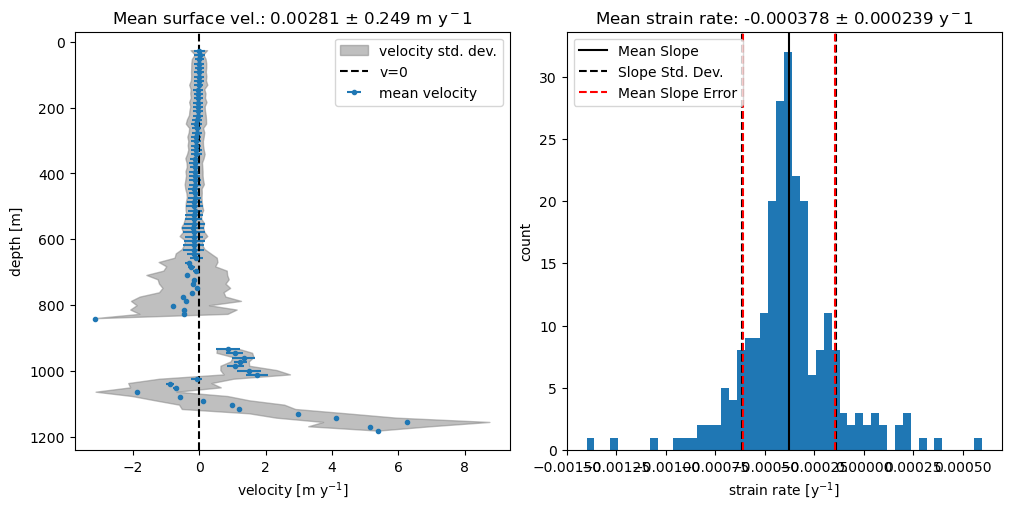

In [175]:
with open(f'A13_22W.pickle', 'rb') as handle:
    ds = pickle.load(handle)
ds_adjust = drop_profile_range(ds,20)
vv = leapfrog_mean_vv(ds_adjust,96, 50, 500, 2)
plot_vv_strain(vv,False)
evaluate_vv_estimates(vv)

/home/jovyan/xapres_package/notebooks/test_notes/streamlined_methods/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom


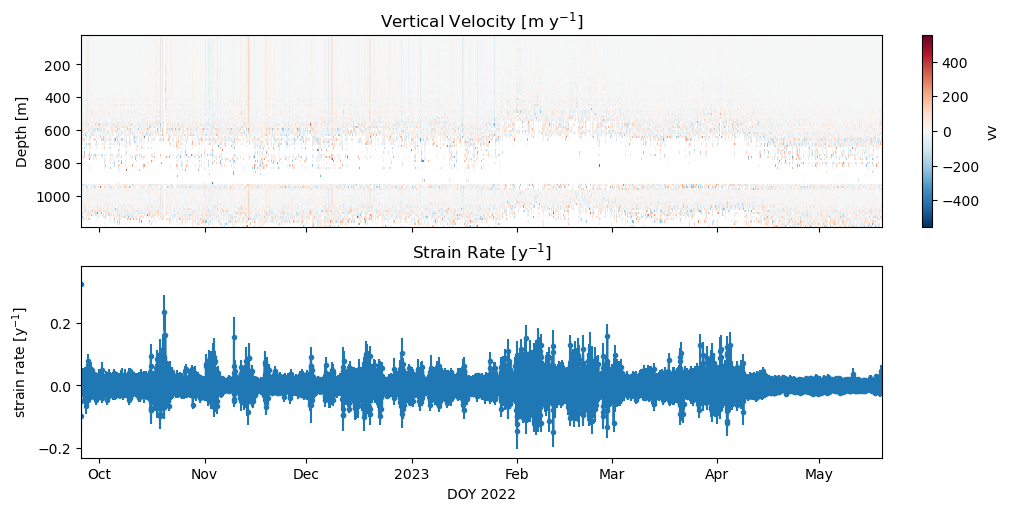

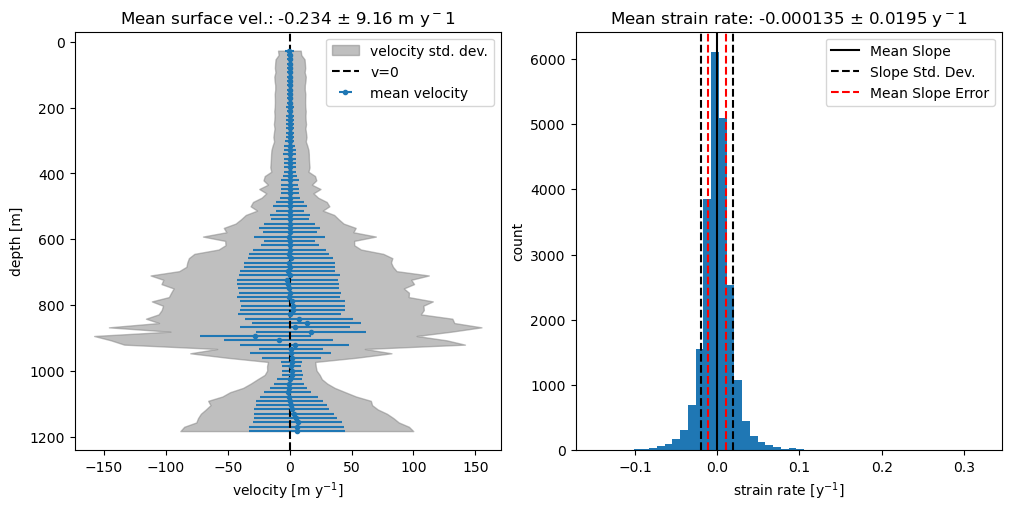

In [176]:
vv_fine = no_coarsen_vv(ds_adjust,50,500,2)
plot_vv_strain(vv_fine,False)
evaluate_vv_estimates(vv_fine)


/srv/conda/envs/notebook/lib/python3.12/site-packages/xarray/core/accessor_dt.py:441: FutureWarning: dt.weekofyear and dt.week have been deprecated. Please use dt.isocalendar().week instead.
  warnings.warn(
/tmp/ipykernel_956/1773200203.py:136: UserWarning: Converting non-nanosecond precision timedelta values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  time_numeric = (timeseries_interp['time'] - timeseries_interp['time'][0]).astype('timedelta64[s]').astype('float64')/1e9
/tmp/ipykernel_956/1773200203.py:136: UserWarning: Converting non-nanosecond precision timedelta values to nanosecond precision. This behavior can eventually be relaxed in xarr

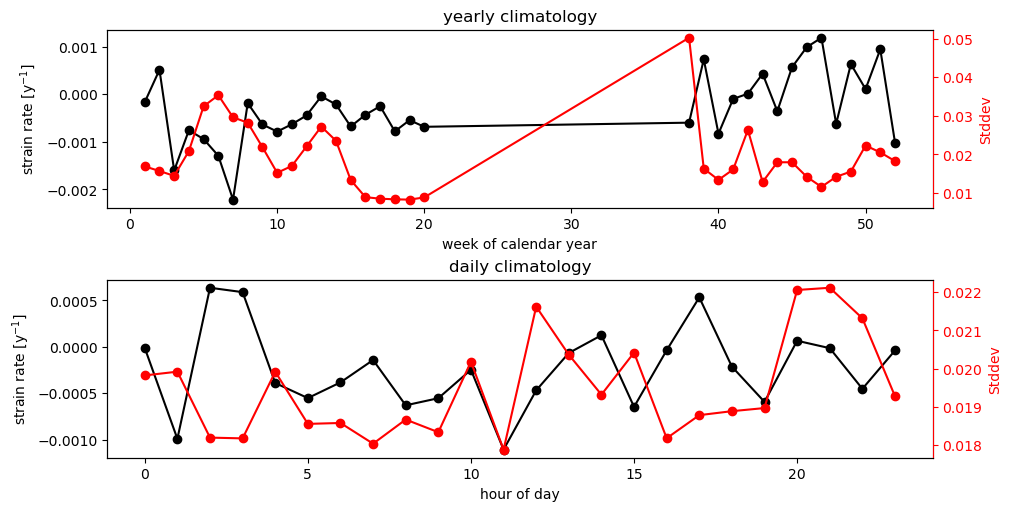

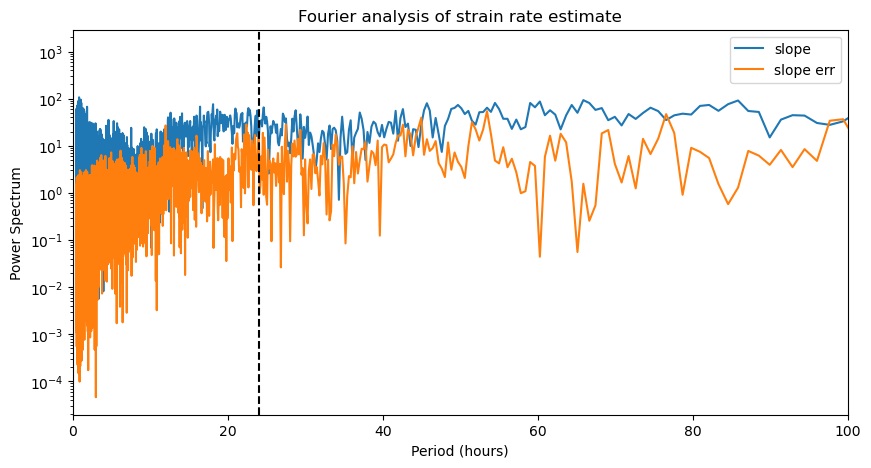

In [177]:
evaluate_vv_fine(vv_fine)
fourier_vvfine(vv_fine)

## A13 23S

/home/jovyan/xapres_package/notebooks/test_notes/streamlined_methods/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom


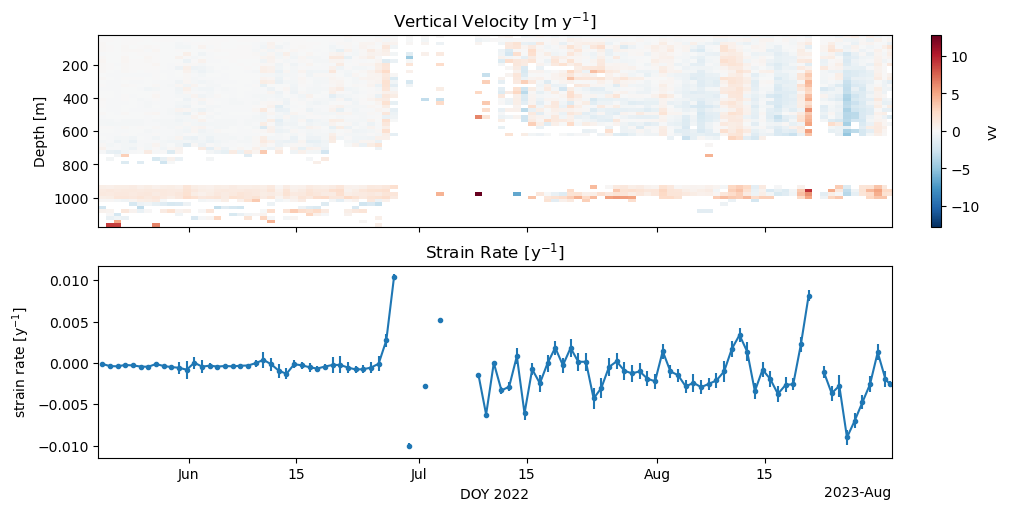

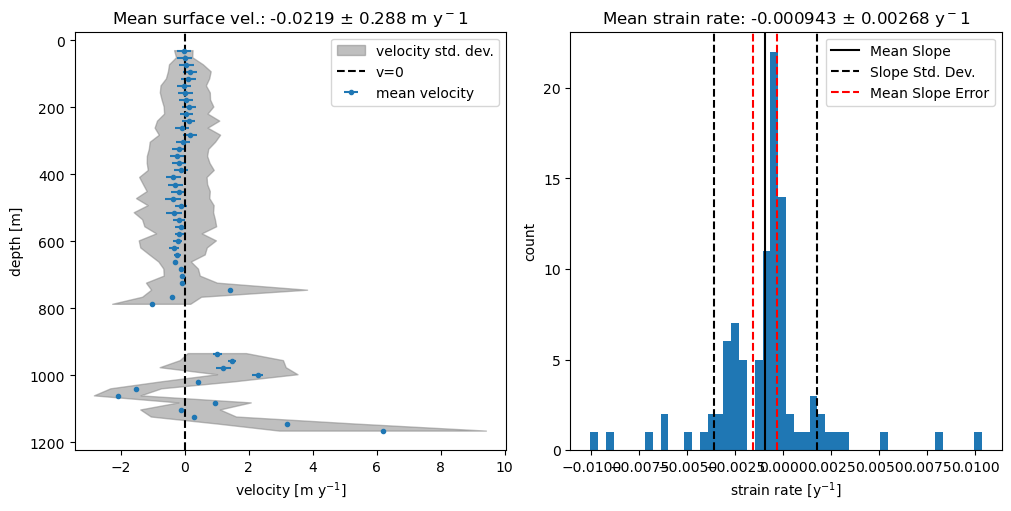

In [178]:
with open(f'A13_23S.pickle', 'rb') as handle:
    ds = pickle.load(handle)
ds_adjust = drop_profile_range(ds,20)
vv = leapfrog_mean_vv(ds_adjust,96*3, 50, 500, 2)
plot_vv_strain(vv,False)
evaluate_vv_estimates(vv)

/home/jovyan/xapres_package/notebooks/test_notes/streamlined_methods/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom


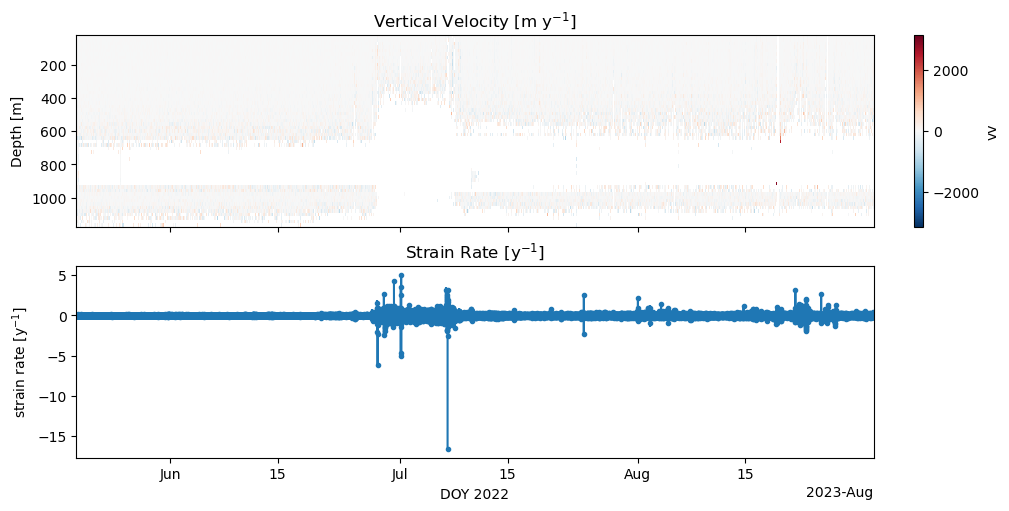

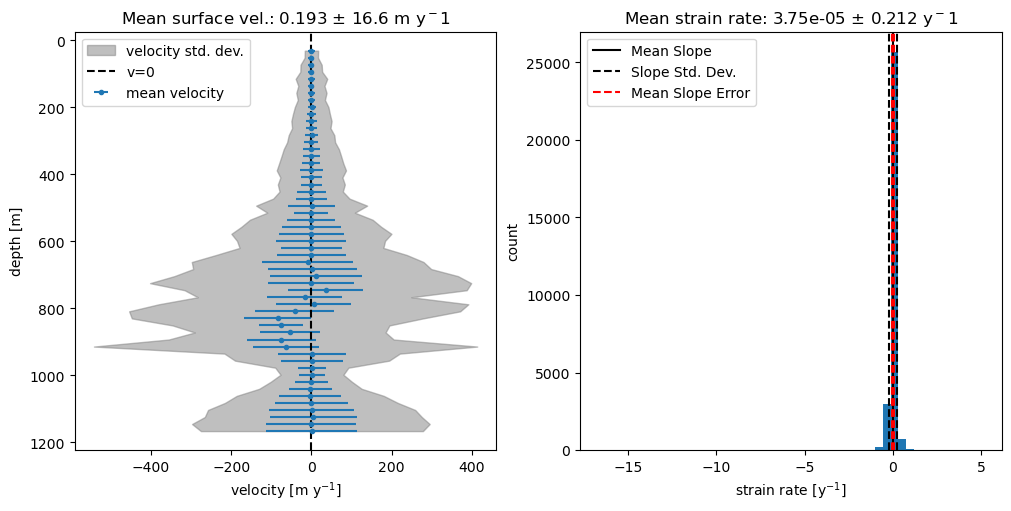

In [179]:
vv_fine = no_coarsen_vv(ds_adjust,50,500,2)
plot_vv_strain(vv_fine,False)
evaluate_vv_estimates(vv_fine)


/srv/conda/envs/notebook/lib/python3.12/site-packages/xarray/core/accessor_dt.py:441: FutureWarning: dt.weekofyear and dt.week have been deprecated. Please use dt.isocalendar().week instead.
  warnings.warn(
/tmp/ipykernel_956/1773200203.py:136: UserWarning: Converting non-nanosecond precision timedelta values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  time_numeric = (timeseries_interp['time'] - timeseries_interp['time'][0]).astype('timedelta64[s]').astype('float64')/1e9
/tmp/ipykernel_956/1773200203.py:136: UserWarning: Converting non-nanosecond precision timedelta values to nanosecond precision. This behavior can eventually be relaxed in xarr

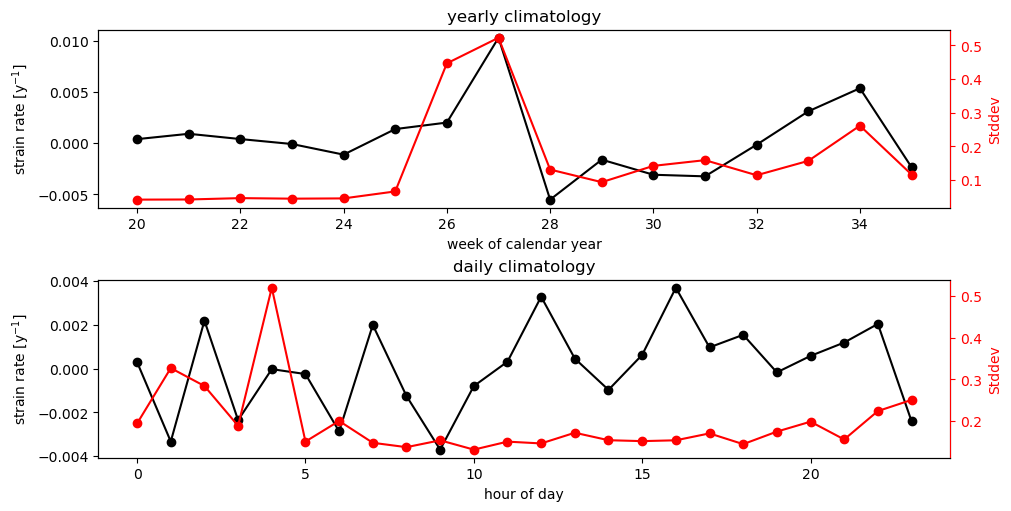

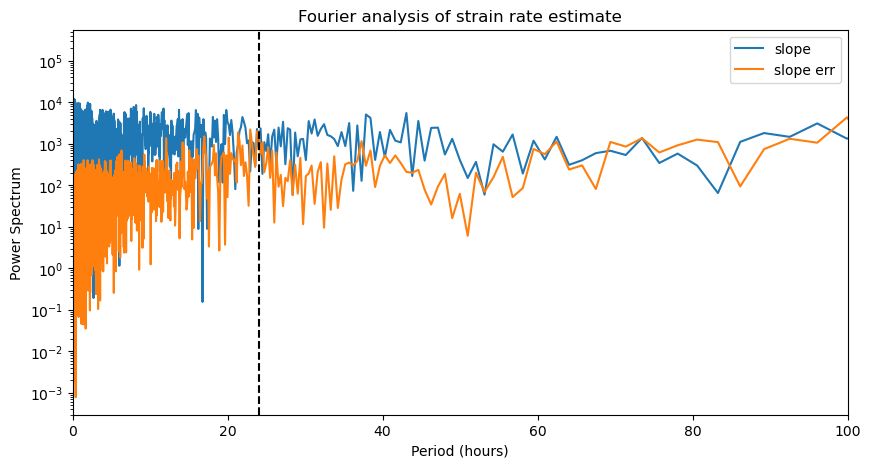

In [181]:
evaluate_vv_fine(vv_fine)
fourier_vvfine(vv_fine)

## A14 S22

/home/jovyan/xapres_package/notebooks/test_notes/streamlined_methods/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom


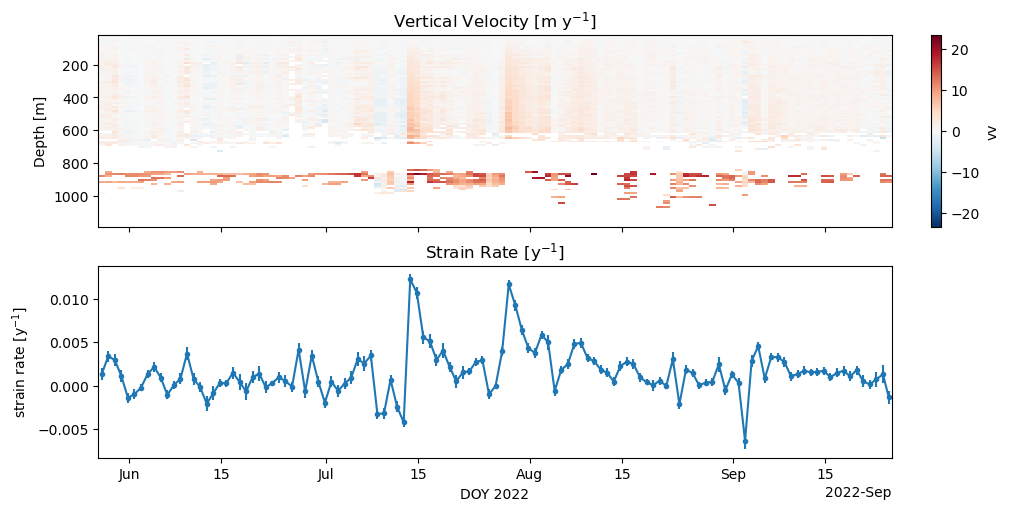

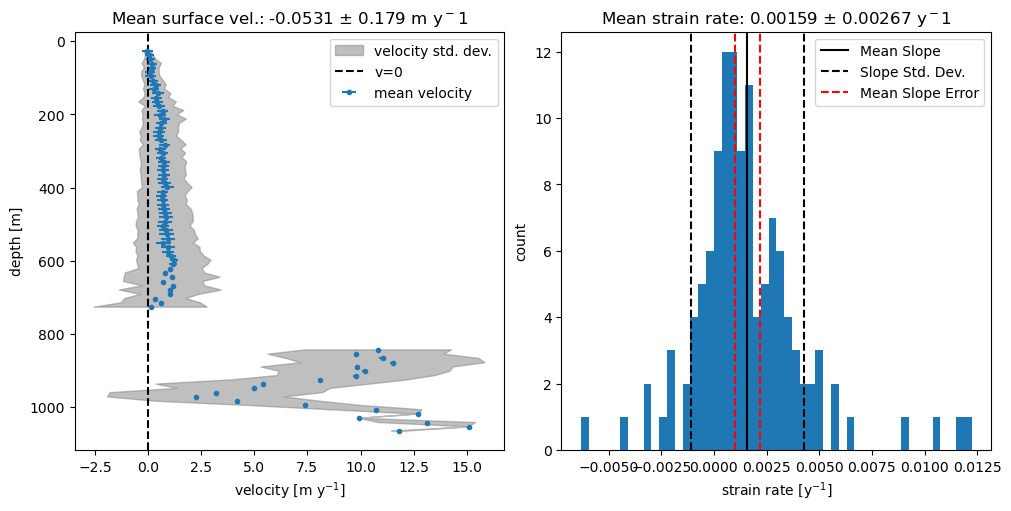

In [182]:
with open(f'A14_22S.pickle', 'rb') as handle:
    ds = pickle.load(handle)
ds_adjust = drop_profile_range(ds,20)
vv = leapfrog_mean_vv(ds_adjust,96, 50, 500, 2)
plot_vv_strain(vv,False)
evaluate_vv_estimates(vv)

/home/jovyan/xapres_package/notebooks/test_notes/streamlined_methods/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom


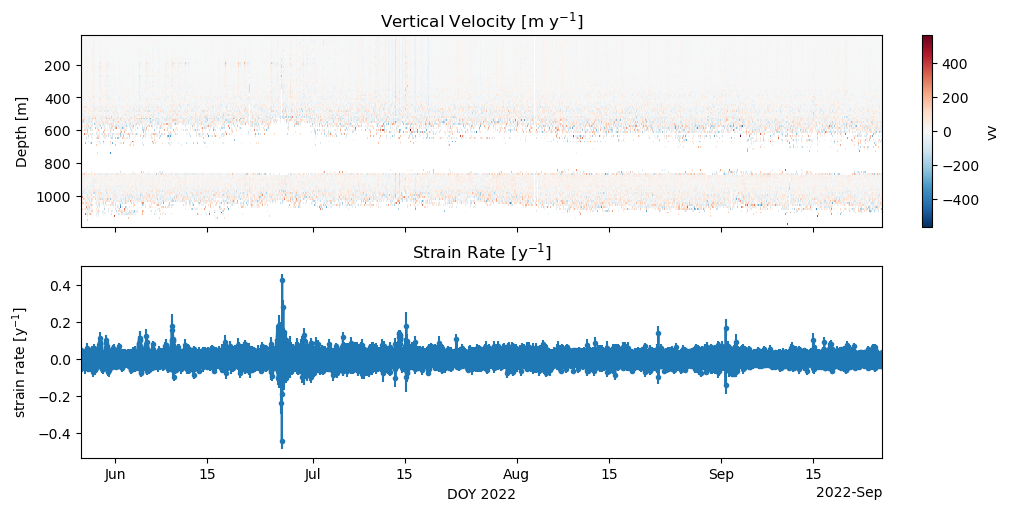

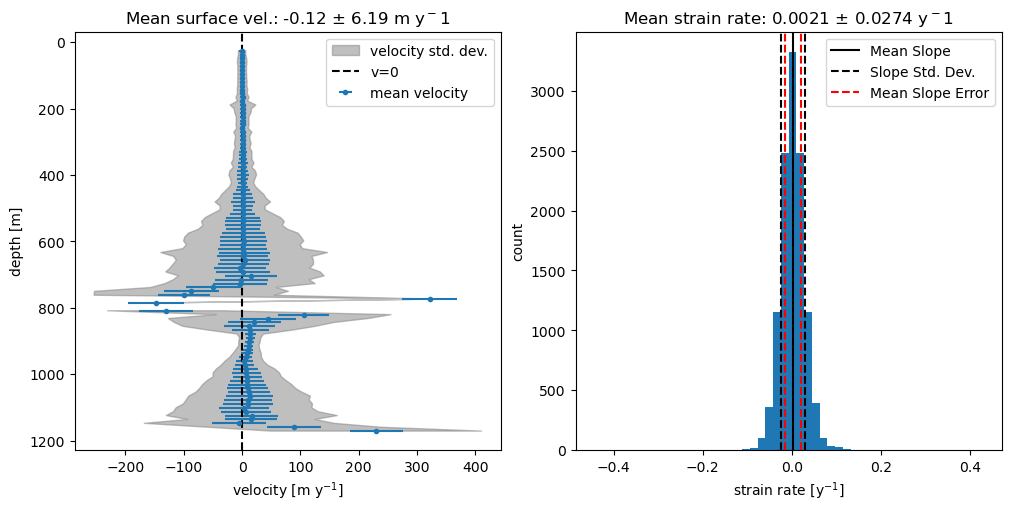

In [183]:
vv_fine = no_coarsen_vv(ds_adjust,50,500,2)
plot_vv_strain(vv_fine,False)
evaluate_vv_estimates(vv_fine)


/srv/conda/envs/notebook/lib/python3.12/site-packages/xarray/core/accessor_dt.py:441: FutureWarning: dt.weekofyear and dt.week have been deprecated. Please use dt.isocalendar().week instead.
  warnings.warn(
/tmp/ipykernel_956/1773200203.py:136: UserWarning: Converting non-nanosecond precision timedelta values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  time_numeric = (timeseries_interp['time'] - timeseries_interp['time'][0]).astype('timedelta64[s]').astype('float64')/1e9
/tmp/ipykernel_956/1773200203.py:136: UserWarning: Converting non-nanosecond precision timedelta values to nanosecond precision. This behavior can eventually be relaxed in xarr

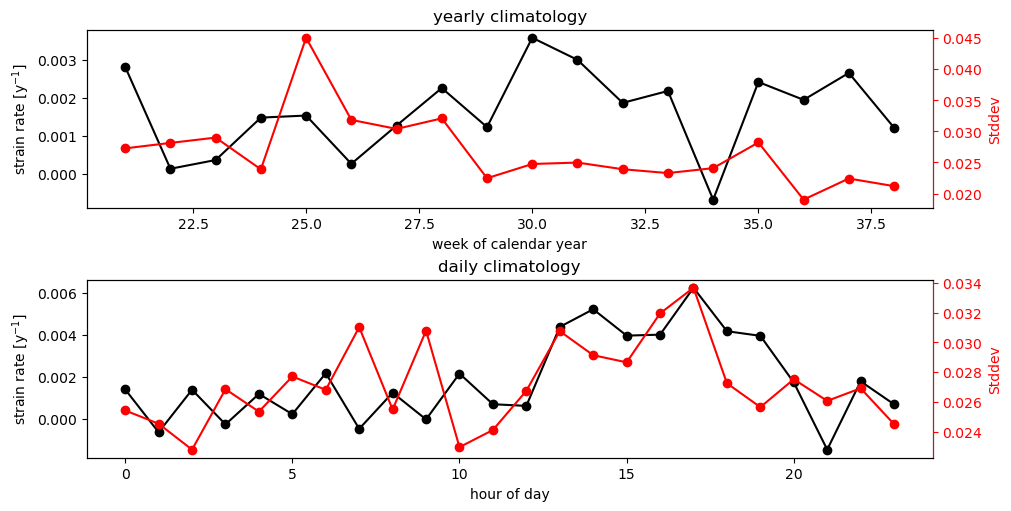

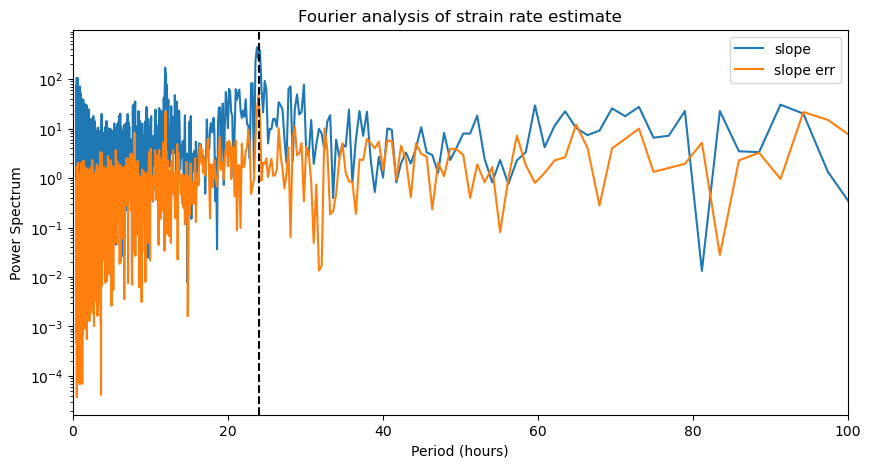

In [184]:
evaluate_vv_fine(vv_fine)
fourier_vvfine(vv_fine)

## A14 Winter

/home/jovyan/xapres_package/notebooks/test_notes/streamlined_methods/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom


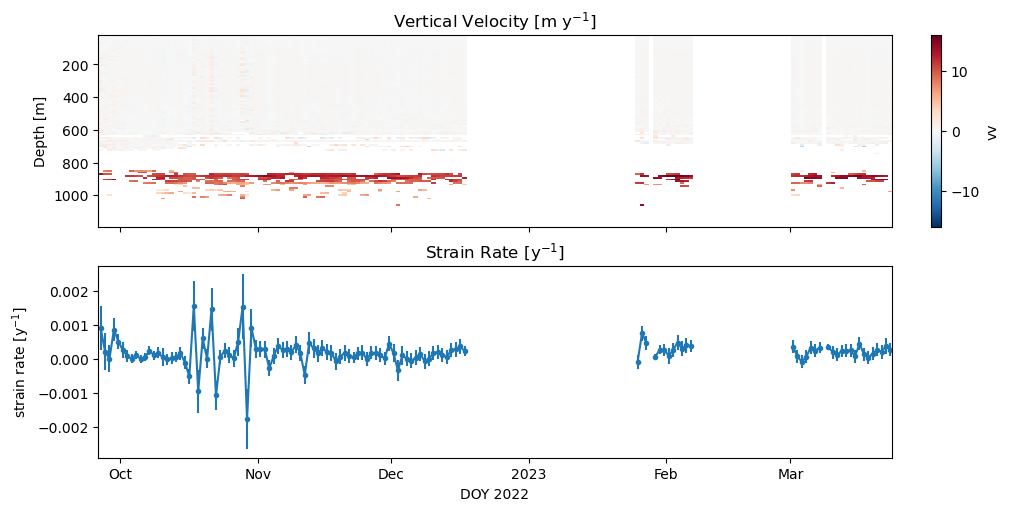

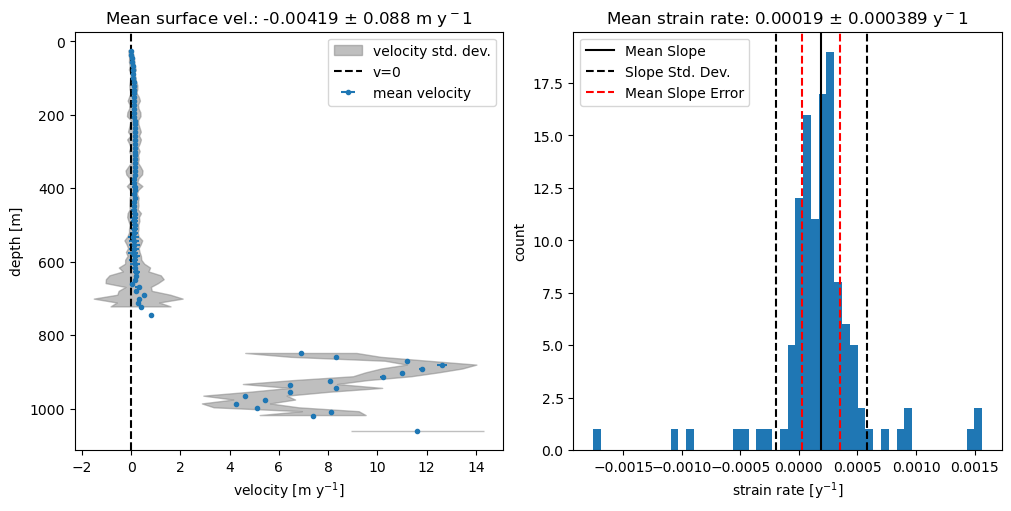

In [185]:
with open(f'A14_22W.pickle', 'rb') as handle:
    ds = pickle.load(handle)
ds_adjust = drop_profile_range(ds,20)
vv = leapfrog_mean_vv(ds_adjust,96, 50, 500, 2)
plot_vv_strain(vv,False)
evaluate_vv_estimates(vv)

/home/jovyan/xapres_package/notebooks/test_notes/streamlined_methods/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom


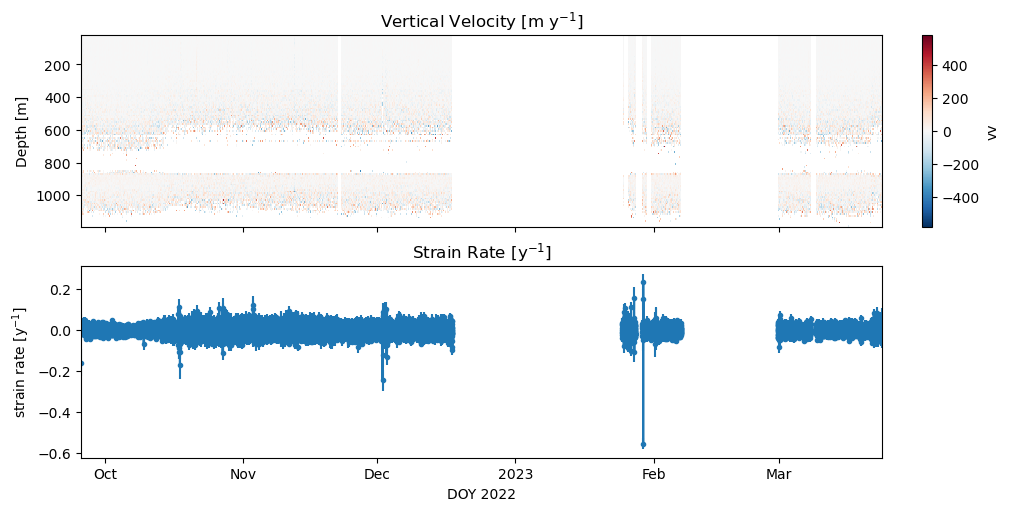

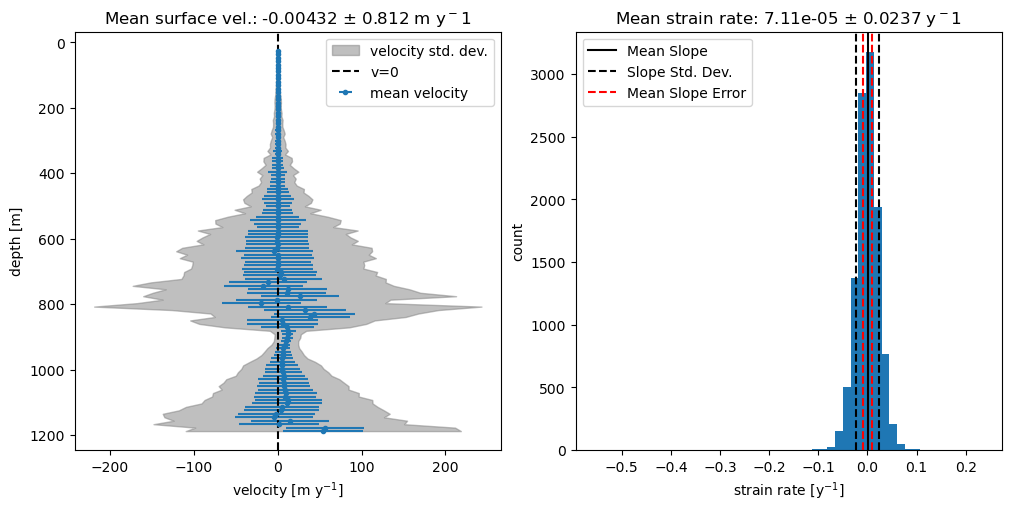

In [186]:
vv_fine = no_coarsen_vv(ds_adjust,50,500,2)
plot_vv_strain(vv_fine,False)
evaluate_vv_estimates(vv_fine)


/srv/conda/envs/notebook/lib/python3.12/site-packages/xarray/core/accessor_dt.py:441: FutureWarning: dt.weekofyear and dt.week have been deprecated. Please use dt.isocalendar().week instead.
  warnings.warn(
/tmp/ipykernel_956/1773200203.py:136: UserWarning: Converting non-nanosecond precision timedelta values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  time_numeric = (timeseries_interp['time'] - timeseries_interp['time'][0]).astype('timedelta64[s]').astype('float64')/1e9
/tmp/ipykernel_956/1773200203.py:136: UserWarning: Converting non-nanosecond precision timedelta values to nanosecond precision. This behavior can eventually be relaxed in xarr

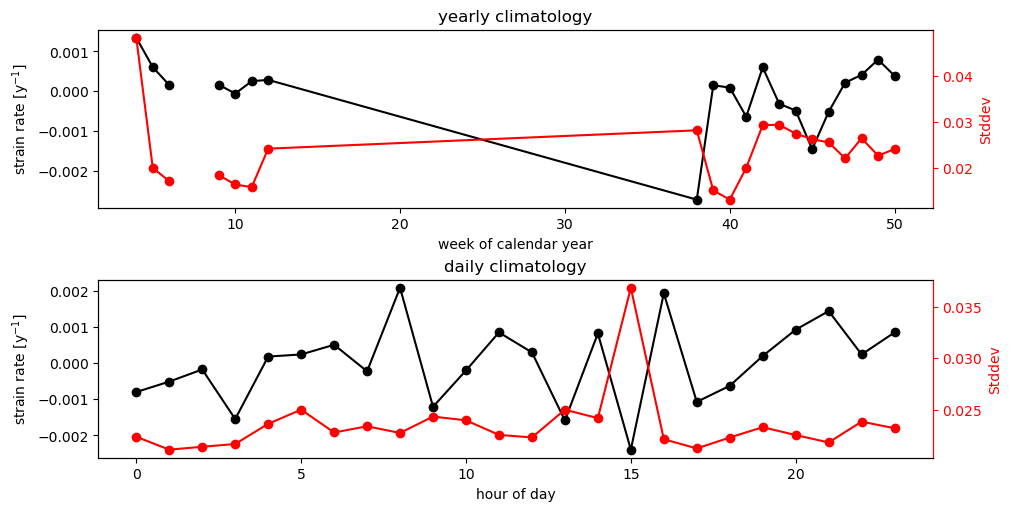

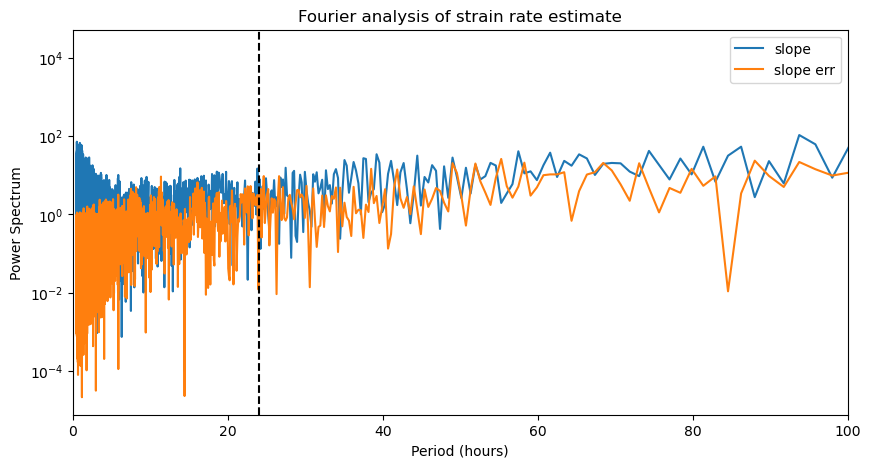

In [187]:
evaluate_vv_fine(vv_fine)
fourier_vvfine(vv_fine)

## A14 S23

/home/jovyan/xapres_package/notebooks/test_notes/streamlined_methods/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom


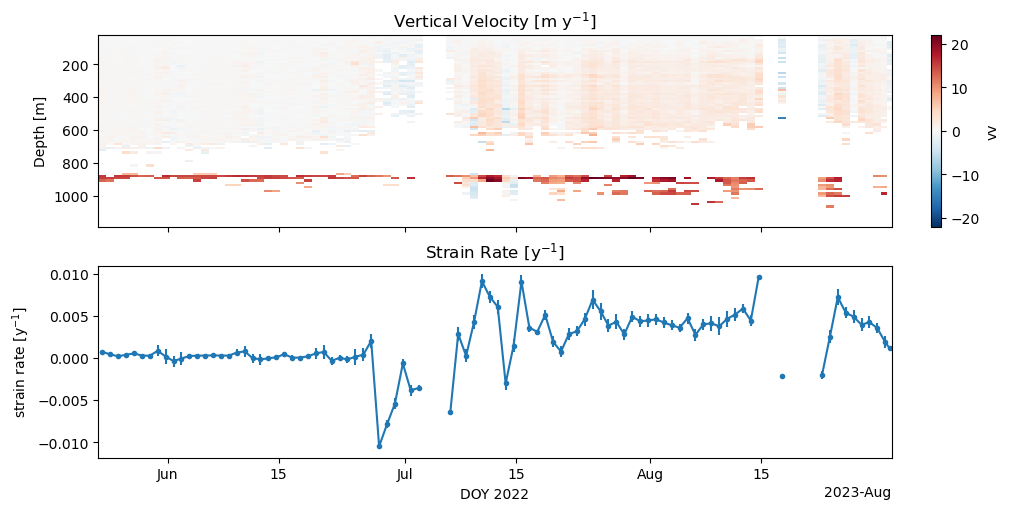

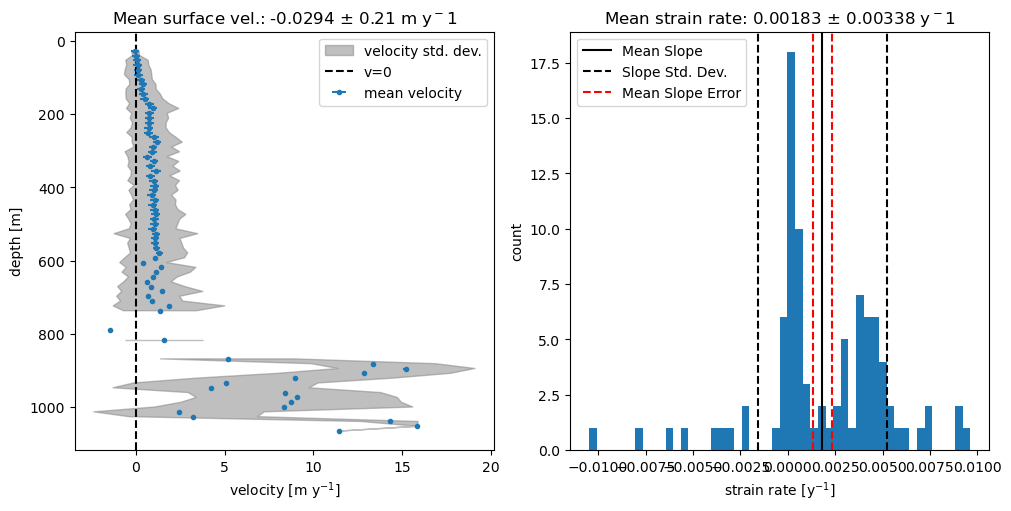

In [188]:
with open(f'A14_23S.pickle', 'rb') as handle:
    ds = pickle.load(handle)
ds_adjust = drop_profile_range(ds,20)
vv = leapfrog_mean_vv(ds_adjust,96, 50, 500, 2)
plot_vv_strain(vv,False)
evaluate_vv_estimates(vv)

/home/jovyan/xapres_package/notebooks/test_notes/streamlined_methods/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom


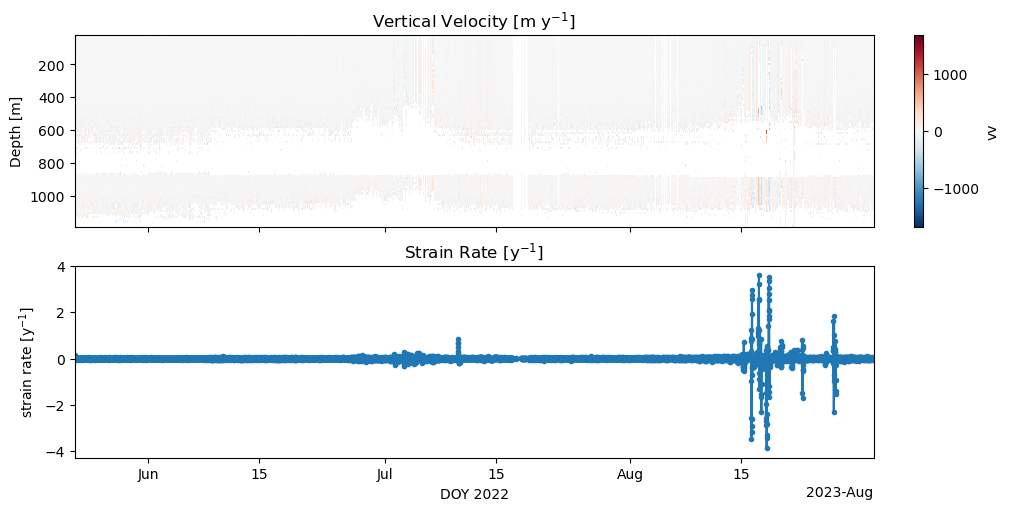

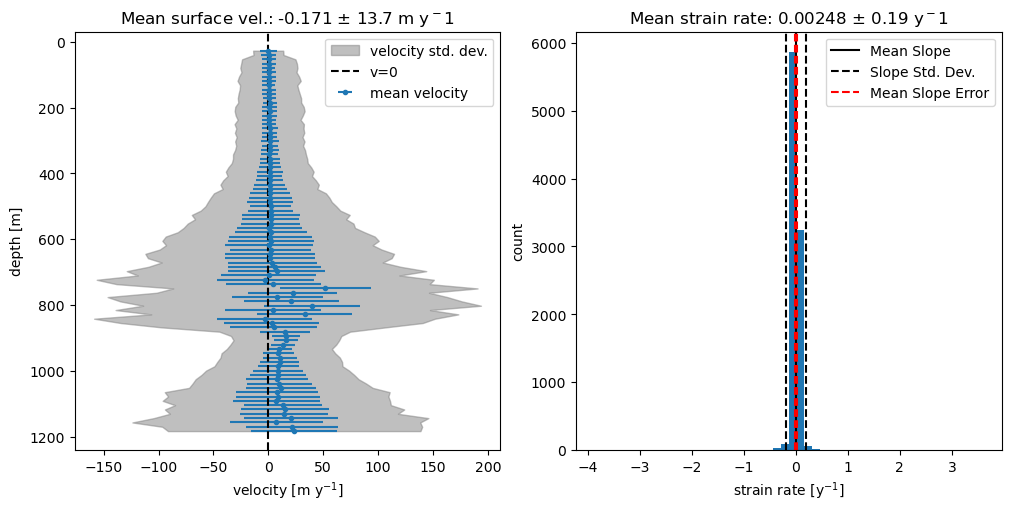

In [189]:
vv_fine = no_coarsen_vv(ds_adjust,50,500,2)
plot_vv_strain(vv_fine,False)
evaluate_vv_estimates(vv_fine)


/srv/conda/envs/notebook/lib/python3.12/site-packages/xarray/core/accessor_dt.py:441: FutureWarning: dt.weekofyear and dt.week have been deprecated. Please use dt.isocalendar().week instead.
  warnings.warn(
/tmp/ipykernel_956/1773200203.py:136: UserWarning: Converting non-nanosecond precision timedelta values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  time_numeric = (timeseries_interp['time'] - timeseries_interp['time'][0]).astype('timedelta64[s]').astype('float64')/1e9
/tmp/ipykernel_956/1773200203.py:136: UserWarning: Converting non-nanosecond precision timedelta values to nanosecond precision. This behavior can eventually be relaxed in xarr

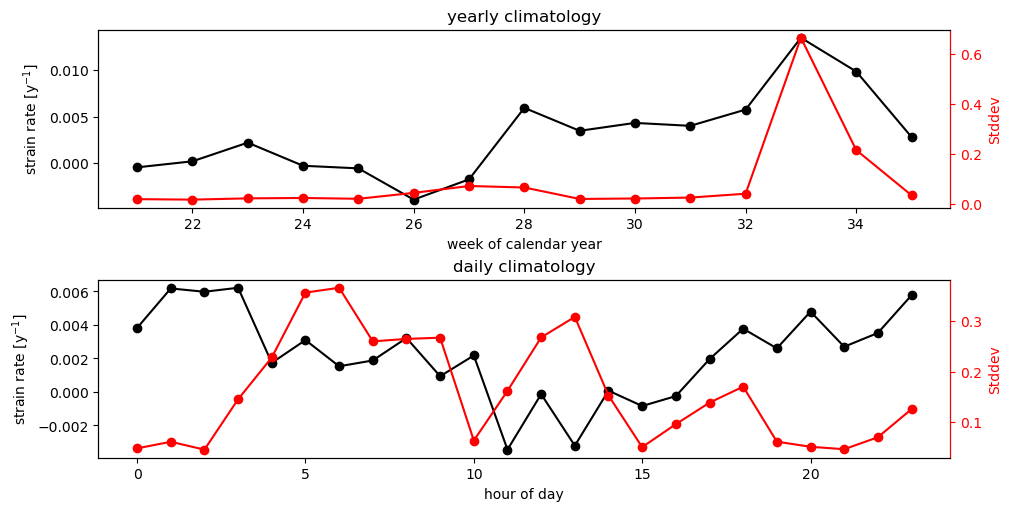

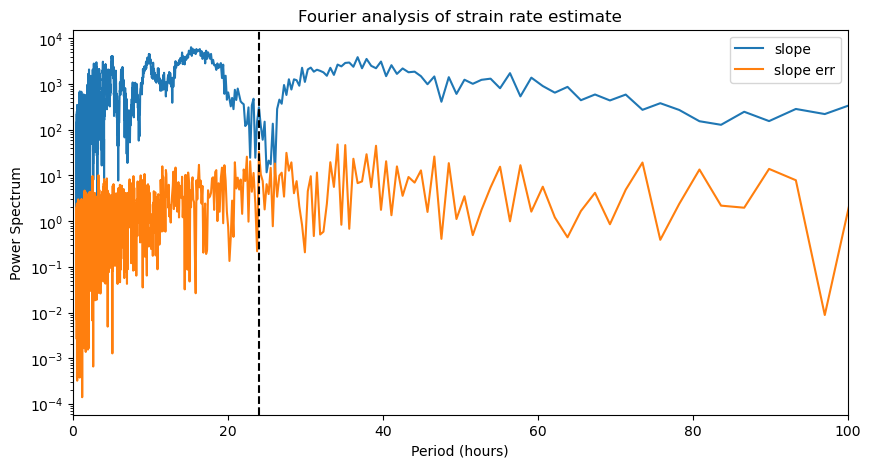

In [190]:
evaluate_vv_fine(vv_fine)
fourier_vvfine(vv_fine)